
------

### ---- EXPLORACIÓN 20 RATAS SANAS TH = 0.0 VERSION FINAL: FILTRADO, PROMEDIO Y SELECCIÓN ----
#### DATOS ALEJANDRO (1-20) 22.12.25

------

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import os
from pathlib import Path
from scipy import stats
from scipy.signal import find_peaks
from scipy.stats import entropy, wasserstein_distance
from sklearn.cluster import KMeans
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.metrics import silhouette_score, davies_bouldin_score
from collections import defaultdict
from collections import Counter

# HELPER FUNCTIONS

# --- Construcción robusta del name_map con IDs reales ---
def make_name_map_from_ids(roi_names, left_ids, right_ids):
    """
    roi_names: lista de 78 nombres base en el orden correcto del atlas.
    left_ids, right_ids: listas con los IDs REALES que corresponden a esos 78 nombres.
                         Deben tener len()==len(roi_names).
    Devuelve dict {roi_id: "L-<name>" / "R-<name>"}.
    """
    if len(left_ids) != len(roi_names) or len(right_ids) != len(roi_names):
        raise ValueError("left_ids y right_ids deben tener la misma longitud que roi_names (79).")

    name_map = {}
    for k, rid in enumerate(left_ids):
        name_map[int(rid)] = f"L-{roi_names[k]}"
    for k, rid in enumerate(right_ids):
        name_map[int(rid)] = f"R-{roi_names[k]}"
    return name_map

# --- Etiquetador que NO asume contigüidad ---
def roi_label(idx, name_map):
    """
    idx: ROI id real (disperso). name_map: dict {id: 'L-Name'/'R-Name'}.
    """
    try:
        return name_map[int(idx)]
    except KeyError:
        return f"ID{int(idx)}"  # fallback visible

## 2. Diferencias clave con el notebook de 1 rata

| Aspecto | Notebook actual | Nuevo enfoque multi-rata |
|---------|-----------------|--------------------------|
| Input | `pickle` con delays crudos | `.dat` con fits (medias/stds) |
| Estructura | `dict[(i,j)] → array(N×6)` | Probablemente matriz o lista de parámetros |
| n_fibers | Por streamline | Agregado en el fit |
| CV/dispersión | Calculado desde delays | Ya resumido o recalcular desde parámetros |
| Multi-sujeto | No aplica | Agregar/promediar entre 18 ratas |

## 3. Flujo propuesto (adaptado)

### Fase A: Carga y consolidación
1. **Leer todos los `.dat`** → tabla unificada por rata
2. **Estructura target**: `DataFrame` con columnas:
   - `rat_id`, `roi_i`, `roi_j`, `n_fibers`, `tau_mean_ms`, `tau_std_ms`, ...
3. **Filtrar conexiones**: `n_fibers ≥ umbral` (50-100)

### Fase B: Análisis por rata y agregado
4. **Métricas por rata**:
   - Distribuciones de τ por conexión
   - Relación τ~D (si D está en los fits)
5. **Agregación entre ratas**:
   - Media/mediana de τ por conexión (i,j) across ratas
   - Variabilidad inter-sujeto (CV entre ratas)
6. **Selección robusta**:
   - Conexiones presentes en ≥ N/2 ratas (e.g., ≥10/18)
   - Bajo CV inter-rata
   - Buen n_fibers promedio



### Fase C: Categorización y clustering
7. Aplicar misma lógica del notebook:
   - Intra/inter hemisférico
   - Hipocampo-PFC, tálamo-cortical
   - Clustering por forma de distribución (si hay parámetros de fit suficientes)

### 1. Carga consolidada - Nombres + Datos

In [2]:
# === CELDA 2: Carga de nombres ROI ===

os.chdir("../..") if os.getcwd().endswith('data_analysis') else None

# Path datos th=0.0 healthy
path = './data/raw/'

# Buscar archivo de nombres
names = [f for f in os.listdir(path) if 'name' in f.lower()]

if names:
    with open(path + names[0], 'r') as f:
        roi_names = [line.strip() for line in f.readlines()][1:] #TODO REVISAR PRIMER LABEL


print(f"✓ ROIs cargados: {len(roi_names)}")
print(f"Primeros 5: {roi_names[:5]}")

✓ ROIs cargados: 78
Primeros 5: ['White matter', 'Ventricles', 'Superior colliculus', 'Olfactory bulb', 'Lateral lemniscus']


In [3]:
# === CELDA 3: Carga de datos .dat ===

CONDITION = 'healthy' 

def load_all_rats(data_dir, threshold='0.0', condition='healthy'):
    """Carga archivos .dat de todas las ratas"""
    rats = {}
    path = Path(data_dir) / f'rat_delays_fibers_{threshold}' / f'th-{threshold}_{condition}'
    
    for rat_dir in sorted(path.glob('R*')):
        if not rat_dir.is_dir():
            continue
            
        rat_id = rat_dir.name
        dat_file = rat_dir / f'th-{threshold}_{rat_id}_b20_r_Fit_Histogram_Tau_all_fibers.dat'
        
        if dat_file.exists():
            with open(dat_file, 'rb') as fh:
                rats[rat_id] = pickle.load(fh)
    
    return rats

# Cargar
all_rats = load_all_rats('./data/raw/', threshold='0.0', condition=CONDITION)

print(f"✓ Ratas: {sorted(all_rats.keys())}")
print(f"✓ Total: {len(all_rats)}")
if all_rats:
    first = list(all_rats.keys())[0]
    print(f"✓ Conexiones {first}: {len(all_rats[first])}")
    # Mostrar estructura de una conexión
    sample_key = list(all_rats[first].keys())[0]
    sample_data = np.array(all_rats[first][sample_key])
    print(f"✓ Shape conexión {sample_key}: {np.array(sample_data).shape}")

✓ Ratas: ['R01', 'R02', 'R03', 'R04', 'R05', 'R06', 'R07', 'R08', 'R09', 'R10', 'R12', 'R13', 'R14', 'R15', 'R16', 'R17', 'R18', 'R19']
✓ Total: 18
✓ Conexiones R01: 3937
✓ Shape conexión (3, 4): (13, 6)


### Celda 4: Name map y exploración inicial

In [4]:
left_ids = range(0, 78)   # IDs del 1 al 78 para hemisferio izquierdo
right_ids = range(78, 156)

name_map = make_name_map_from_ids(roi_names, left_ids, right_ids)

# Exploración: conexiones comunes entre ratas
all_pairs = Counter()
for rat_data in all_rats.values():
    all_pairs.update(rat_data.keys())

print(f"Total conexiones únicas: {len(all_pairs)}")
print(f"Conexiones en ≥9 ratas: {sum(1 for c in all_pairs.values() if c >= 9)}")
print(f"\nTop 10 conexiones más frecuentes:")
for (i,j), count in all_pairs.most_common(10):
    print(f"  {roi_label(i, name_map)} → {roi_label(j, name_map)}: {count} ratas")

Total conexiones únicas: 7263
Conexiones en ≥9 ratas: 3409

Top 10 conexiones más frecuentes:
  L-Olfactory bulb → L-Secondary auditory area: 18 ratas
  L-Olfactory bulb → L-Nucleus accumbens: 18 ratas
  L-Olfactory bulb → L-Subiculum: 18 ratas
  L-Olfactory bulb → L-Subthalamic nucleus: 18 ratas
  L-Olfactory bulb → L-Entopeduncular nucleus: 18 ratas
  L-Olfactory bulb → L-Hypothalamic region, unspecified: 18 ratas
  L-Olfactory bulb → L-Pontine nuclei: 18 ratas
  L-Olfactory bulb → L-Postrhinal cortex: 18 ratas
  L-Olfactory bulb → L-Secondary somatosensory area: 18 ratas
  L-Olfactory bulb → L-Primary motor area: 18 ratas


Perfecto, los primeros pasos son correctos:

## Celdas 3-4: Carga y Exploración ✅

Observaciones:

- 18 ratas (sin R11 como esperado)
- R01: 3937 conexiones → threshold 0.0 es menos restrictivo que 0.2
- Shape (13, 6): 13 fibras × 6 columnas (D, τ, v, w, n_fibers, w_sum)
- 7263 conexiones únicas, 3409 en ≥9 ratas (~47% solapamiento)
- Olfactory bulb izquierdo aparece como hub (todas las top 10)


In [5]:
# === Exploración estructura array ===

sample_rat = 'R01'
sample_pairs = list(all_rats[sample_rat].items())[:5]

print("Shape y rangos por columna (primeras 5 conexiones):\n")
for (i,j), arr in sample_pairs:
    print(f"{(i,j)}: shape={np.array(arr).shape}")
    for col in range(np.array(arr).shape[1]):
        print(f"  Col {col}: [{np.array(arr)[:,col].min():.4f}, {np.array(arr)[:,col].max():.4f}], mean={np.array(arr)[:,col].mean():.4f}")
    print()

Shape y rangos por columna (primeras 5 conexiones):

(3, 4): shape=(13, 6)
  Col 0: [0.0017, 0.0047], mean=0.0022
  Col 1: [0.0111, 0.0131], mean=0.0119
  Col 2: [2.7750, 6.5724], mean=5.7584
  Col 3: [3.2780, 3.4299], mean=3.3578
  Col 4: [0.0000, 0.0000], mean=0.0000
  Col 5: [0.2284, 0.2751], mean=0.2652

(3, 6): shape=(224, 6)
  Col 0: [0.0000, 0.0011], mean=0.0001
  Col 1: [0.0001, 0.0031], mean=0.0004
  Col 2: [1.3278, 11.2821], mean=5.5422
  Col 3: [2.8218, 4.7755], mean=3.6021
  Col 4: [0.0000, 0.0880], mean=0.0091
  Col 5: [0.0726, 0.3946], mean=0.2293

(3, 9): shape=(4, 6)
  Col 0: [0.0017, 0.0021], mean=0.0020
  Col 1: [0.0124, 0.0133], mean=0.0127
  Col 2: [6.0379, 7.8171], mean=6.4827
  Col 3: [3.3076, 3.3483], mean=3.3381
  Col 4: [0.0000, 0.0000], mean=0.0000
  Col 5: [0.3027, 0.3086], mean=0.3057

(3, 10): shape=(28, 6)
  Col 0: [0.0008, 0.0051], mean=0.0020
  Col 1: [0.0055, 0.0071], mean=0.0065
  Col 2: [1.2896, 8.1585], mean=5.3743
  Col 3: [3.2445, 3.6880], mean=3.4

Interpretación basada en rangos:

COL_0: [0.0001-0.0051] → τ en segundos = 0.1-5.1 ms ✓
COL_1: [0.0001-0.0133] → D en metros = 0.1-13.3 mm ✓
COL_2: [1.3-13.2]      → V en m/s ✓

Columnas desconocidas:
COL_3: [2.8-4.8], mean~3.3 → constante, posible peso/parámetro
COL_4: casi todo 0, max~0.2 → probablemente n_fibers normalizado
COL_5: [0.07-0.4], mean~0.25 → otro peso/factor

=== Verificación τ = D/V ===
τ medido: 0.0001 s
D/V calc: 0.0001 s
Ratio: 1.000


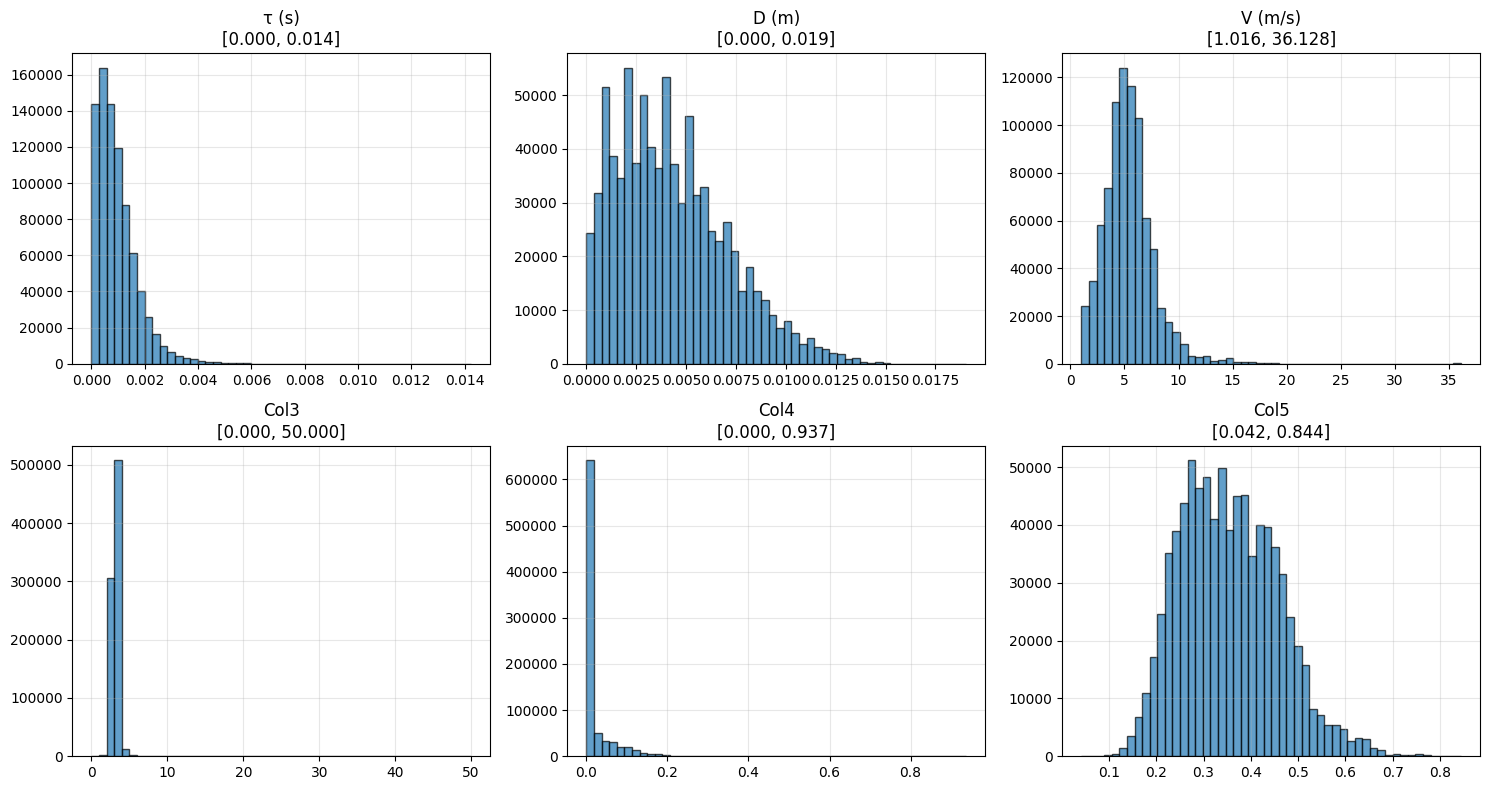

Fibras válidas R01: 833575


In [6]:
# === Interpretación columnas ===

print("Interpretación basada en rangos:\n")
print("COL_0: [0.0001-0.0051] → τ en segundos = 0.1-5.1 ms ✓")
print("COL_1: [0.0001-0.0133] → D en metros = 0.1-13.3 mm ✓")  
print("COL_2: [1.3-13.2]      → V en m/s ✓")
print("\nColumnas desconocidas:")
print("COL_3: [2.8-4.8], mean~3.3 → constante, posible peso/parámetro")
print("COL_4: casi todo 0, max~0.2 → probablemente n_fibers normalizado")
print("COL_5: [0.07-0.4], mean~0.25 → otro peso/factor")

# Verificar relación τ ≈ D/V
sample_arr = np.array(sample_pairs[1][1])  # conexión con más datos
tau = sample_arr[:, 0]
D = sample_arr[:, 1]
V = sample_arr[:, 2]
tau_calc = D / V

print("\n=== Verificación τ = D/V ===")
print(f"τ medido: {tau.mean():.4f} s")
print(f"D/V calc: {tau_calc.mean():.4f} s")
print(f"Ratio: {tau.mean()/tau_calc.mean():.3f}")

# === Histogramas filtrando vacíos ===
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

# Filtrar arrays no vacíos
valid_arrays = [arr for arr in all_rats['R01'].values() if len(arr) > 0]
all_data = np.vstack(valid_arrays)

labels = ['τ (s)', 'D (m)', 'V (m/s)', 'Col3', 'Col4', 'Col5']

for col in range(6):
    axes[col].hist(all_data[:, col], bins=50, edgecolor='k', alpha=0.7)
    axes[col].set_title(f'{labels[col]}\n[{all_data[:,col].min():.3f}, {all_data[:,col].max():.3f}]')
    axes[col].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Fibras válidas R01: {all_data.shape[0]}")

### Celda 5: Limpieza por rata
    - Min fibers: 25

In [7]:
# Columnas (D y V no se usan en la limpieza; se dejan por compatibilidad)
COL_TAU = 0
COL_D   = 1
COL_V   = 2

def clean_data(
    data: dict,
    *,
    min_n_fibers: int = 50,
    enforce_positive: bool = True,
    tau_quantiles: tuple[float, float] | None = (0.005, 0.995),
) -> tuple[dict, pd.DataFrame, dict]:
    """
    Limpia mediciones por par (i,j) sin chequeo τ≈D/V.
    - Filtros: finitos, (opcional) τ,D,V > 0, cuantiles de τ por par.
    - Umbral min_n_fibers antes y después de limpiar.
    Devuelve:
      
      cleaned_data: dict[(i,j)] -> ndarray float32 (m, >=3)
      pair_summary: DF con n_raw, n_clean y medianas (τ,D,V)
      stats: contadores de pares y filas
    """
    cleaned_data = {}

    pair_stats = {
        "pairs_original": len(data),
        "pairs_empty_raw": 0,
        "pairs_raw_lt_min": 0,
        "pairs_all_invalid": 0,
        "pairs_after_lt_min": 0,
        "pairs_kept": 0,
    }
    row_stats = {
        "rows_total": 0,
        "rows_kept": 0,
        "rows_drop_nan_inf": 0,
        "rows_drop_nonpositive": 0,
        "rows_drop_outlier_tau": 0,
    }

    rows_summary = []

    for (i, j), measurements in data.items():
        if measurements is None or len(measurements) == 0:
            pair_stats["pairs_empty_raw"] += 1
            continue

        arr = np.asarray(measurements)
        # exigimos al menos τ,D,V (>=3 columnas)
        if arr.ndim != 2 or arr.shape[1] < 3:
            pair_stats["pairs_all_invalid"] += 1
            continue

        n_raw = arr.shape[0]
        row_stats["rows_total"] += n_raw
        if n_raw < min_n_fibers:
            pair_stats["pairs_raw_lt_min"] += 1
            continue

        # Finite en τ,D,V
        finite = np.isfinite(arr[:, [COL_TAU, COL_D, COL_V]]).all(axis=1)
        row_stats["rows_drop_nan_inf"] += int((~finite).sum())
        arr = arr[finite]
        if arr.size == 0:
            pair_stats["pairs_all_invalid"] += 1
            continue

        # Positivos (opcional)
        if enforce_positive:
            pos = (arr[:, COL_TAU] > 0) & (arr[:, COL_D] > 0) & (arr[:, COL_V] > 0)
            row_stats["rows_drop_nonpositive"] += int((~pos).sum())
            arr = arr[pos]
            if arr.size == 0:
                pair_stats["pairs_all_invalid"] += 1
                continue

        # Outliers de τ por cuantiles (por par)
        if tau_quantiles is not None and arr.shape[0] >= 5:
            qlo, qhi = tau_quantiles
            tau_vals = arr[:, COL_TAU]
            lo = np.nanquantile(tau_vals, qlo)
            hi = np.nanquantile(tau_vals, qhi)
            in_rng = (tau_vals >= lo) & (tau_vals <= hi)
            row_stats["rows_drop_outlier_tau"] += int((~in_rng).sum())
            arr = arr[in_rng]
            if arr.size == 0:
                pair_stats["pairs_all_invalid"] += 1
                continue

        n_clean = arr.shape[0]
        if n_clean < min_n_fibers:
            pair_stats["pairs_after_lt_min"] += 1
            continue

        cleaned = arr.astype(np.float32, copy=False)
        cleaned_data[(int(i), int(j))] = cleaned
        pair_stats["pairs_kept"] += 1
        row_stats["rows_kept"] += n_clean

        # Resumen por par
        med_tau = float(np.median(cleaned[:, COL_TAU]))
        med_D   = float(np.median(cleaned[:, COL_D]))
        med_V   = float(np.median(cleaned[:, COL_V]))

        rows_summary.append({
            "roi_i": int(i), "roi_j": int(j),
            "roi_name1": roi_label(i, name_map), "roi_name2": roi_label(j, name_map),
            "n_raw": int(n_raw), "n_clean": int(n_clean),
            "tau_med_s": med_tau, "tau_med_ms": med_tau*1e3,
            "D_med_m": med_D, "D_med_mm": med_D*1e3,
            "V_med_mps": med_V,
        })

    pair_summary = pd.DataFrame(rows_summary).sort_values(["roi_i", "roi_j"]).reset_index(drop=True)
    stats = {"pairs": pair_stats, "rows": row_stats}
    return cleaned_data, pair_summary, stats


cleaned_rats = {}
summaries = {}
stats = {}
for rat_id, data in all_rats.items():
    cleaned_rats[rat_id], summaries[rat_id], stats[rat_id] = clean_data(
        data, min_n_fibers=25, enforce_positive=True, tau_quantiles=(0.02, 0.98)
    )
    
    
# Resumen limpieza
print(f"{'Rat':<5} {'Pares orig':<12} {'Pares limpios':<14} {'Fibras orig':<12} {'Fibras limpias'}")
for rat in sorted(cleaned_rats.keys()):
    s = stats[rat]
    print(f"{rat:<5} {s['pairs']['pairs_original']:<12} {s['pairs']['pairs_kept']:<14} "
          f"{s['rows']['rows_total']:<12} {s['rows']['rows_kept']}")
    
cleaned_rats.keys()

Rat   Pares orig   Pares limpios  Fibras orig  Fibras limpias
R01   3937         2250           833575       785538
R02   3283         1899           741008       698981
R03   3615         2076           856659       808902
R04   3888         2243           899790       848940
R05   3268         1811           748580       705714
R06   3881         2311           904949       853384
R07   3681         2171           823088       776888
R08   3753         2129           902072       850596
R09   3925         2213           786554       740178
R10   3813         2199           877288       827508
R12   3362         2003           795277       751065
R13   3334         1930           740927       698857
R14   3360         1994           798416       754443
R15   3644         2152           891428       842525
R16   3410         2032           874979       827553
R17   3786         2174           841754       794254
R18   3461         1912           766008       722161
R19   3556         2

dict_keys(['R01', 'R02', 'R03', 'R04', 'R05', 'R06', 'R07', 'R08', 'R09', 'R10', 'R12', 'R13', 'R14', 'R15', 'R16', 'R17', 'R18', 'R19'])

## Resultados Limpieza - Ratas Sanas (th=0.0)

**Parámetros:**
- `min_n_fibers=25` (umbral relajado vs 50)
- `tau_quantiles=(0.02, 0.98)` (elimina 2% extremos por cada lado)
- `enforce_positive=True`

**Resultados:**
- **Retención pares:** ~57-60% (de ~3500 → ~2000/rata)
- **Retención fibras:** ~94% (pérdida mínima)
- **Consistencia:** muy estable entre ratas (R05 más baja: 55%, R06 más alta: 60%)

**Observaciones:**
- Threshold 0.0 genera ~3500 pares/rata (vs ~1500 en th=0.2)
- La mayoría de pérdidas por `min_n_fibers` (conexiones débiles), no por outliers
- Filtro de outliers elimina ~6% fibras (94% retención excelente)

### - Mostramos los resultados para una rata: 02

    - Claves de pares de ROIs (i,j)

In [8]:
cleaned_rats['R18'].keys()

dict_keys([(3, 6), (3, 26), (3, 29), (3, 30), (3, 32), (3, 34), (3, 35), (3, 37), (3, 48), (3, 55), (3, 58), (3, 59), (3, 60), (3, 69), (3, 82), (3, 105), (3, 109), (3, 124), (3, 127), (3, 139), (4, 8), (4, 9), (4, 24), (4, 25), (4, 27), (4, 28), (4, 29), (4, 35), (4, 36), (4, 38), (4, 42), (4, 49), (4, 51), (4, 53), (4, 54), (4, 62), (4, 63), (4, 106), (4, 121), (4, 130), (4, 141), (5, 9), (5, 10), (5, 19), (5, 24), (5, 28), (5, 31), (5, 33), (5, 35), (5, 40), (5, 42), (5, 53), (5, 58), (5, 59), (6, 12), (6, 18), (6, 19), (6, 29), (6, 35), (6, 37), (6, 53), (6, 56), (7, 12), (7, 13), (7, 14), (7, 29), (7, 30), (7, 45), (7, 46), (7, 47), (7, 48), (7, 49), (7, 50), (7, 53), (7, 56), (7, 57), (7, 58), (7, 59), (7, 65), (7, 66), (7, 72), (8, 11), (8, 27), (8, 29), (8, 42), (8, 49), (8, 51), (8, 53), (8, 54), (8, 62), (8, 63), (8, 68), (8, 73), (8, 74), (9, 10), (9, 19), (9, 24), (9, 27), (9, 28), (9, 29), (9, 31), (9, 33), (9, 34), (9, 35), (9, 36), (9, 38), (9, 40), (9, 42), (9, 51), (9,

### - Resumen de estadísticas descriptivas: Pares, nombres, n_fibras_raw vs n_fibras_clean, medianas de: tau, distancia, velocity

In [9]:
summaries['R02']

,roi_i,roi_j,roi_name1,roi_name2,n_raw,n_clean,tau_med_s,tau_med_ms,D_med_m,D_med_mm,V_med_mps
0,3,4,L-Olfactory bulb,L-Lateral lemniscus,38,36,0.001232,1.232090,0.010775,10.775461,8.937934
1,3,6,L-Olfactory bulb,L-Secondary auditory area,86,82,0.000193,0.193214,0.001743,1.742872,9.355210
2,3,15,L-Olfactory bulb,L-LAT,52,48,0.000212,0.212107,0.001976,1.975678,8.937934
3,3,16,L-Olfactory bulb,L-MED,57,53,0.000122,0.122247,0.001198,1.198068,9.320947
4,3,17,L-Olfactory bulb,L-GENd,43,41,0.000296,0.296038,0.003014,3.013607,10.062608
...,...,...,...,...,...,...,...,...,...,...,...
1894,148,150,R-Prelimbic area,R-Ventrolateral orbital area,401,385,0.000199,0.199235,0.001063,1.063128,5.835845
1895,149,150,R-Frontal association area 3,R-Ventrolateral orbital area,131,124,0.000143,0.142879,0.000939,0.939289,3.065631
1896,149,156,R-Frontal association area 3,ID156,96,92,0.000311,0.311308,0.001640,1.639560,5.266686
1897,150,152,R-Ventrolateral orbital area,R-Dorsolateral orbital area,30,28,0.000180,0.180491,0.001009,1.009227,5.591566


In [10]:
stats['R02']

{'pairs': {'pairs_original': 3283,
  'pairs_empty_raw': 52,
  'pairs_raw_lt_min': 1295,
  'pairs_all_invalid': 0,
  'pairs_after_lt_min': 37,
  'pairs_kept': 1899},
 'rows': {'rows_total': 741008,
  'rows_kept': 698981,
  'rows_drop_nan_inf': 0,
  'rows_drop_nonpositive': 420,
  'rows_drop_outlier_tau': 30986}}

- ### Agregación inter-rata con métricas clave
  - Ordenado por tau_range_mean (prioriza diversidad temporal) + n_rats.

In [11]:
def aggregate_multi_rat(cleaned_rats, min_rats=10):
    """
    Consolida conexiones presentes en ≥ min_rats.
    Devuelve DataFrame con estadísticas inter-rata.
    """
    
    conn_data = defaultdict(lambda: {
        'rats': [], 'tau_med_ms': [], 'tau_range_ms': [], 
        'n_fibers': [], 'D_med_mm': []
    })
    
    for rat_id, data in cleaned_rats.items():
        for (i,j), arr in data.items():
            tau_ms = arr[:, COL_TAU] * 1e3
            D_mm = arr[:, COL_D] * 1e3
            
            conn_data[(i,j)]['rats'].append(rat_id)
            conn_data[(i,j)]['tau_med_ms'].append(np.median(tau_ms))
            conn_data[(i,j)]['tau_range_ms'].append(np.ptp(tau_ms))  # max-min
            conn_data[(i,j)]['n_fibers'].append(len(tau_ms))
            conn_data[(i,j)]['D_med_mm'].append(np.median(D_mm))
    
    rows = []
    for (i,j), stats in conn_data.items():
        n_rats = len(stats['rats'])
        if n_rats < min_rats:
            continue
        
        tau_vals = np.array(stats['tau_med_ms'])
        rows.append({
            'roi_i': int(i), 'roi_j': int(j),
            'pair_label': f"{roi_label(i, name_map)} → {roi_label(j, name_map)}",
            'n_rats': n_rats,
            'tau_mean_ms': tau_vals.mean(),
            'tau_std_inter': tau_vals.std(),           # variabilidad entre ratas
            'cv_inter': tau_vals.std() / tau_vals.mean(),
            'tau_range_mean': np.mean(stats['tau_range_ms']),  # rango promedio
            'n_fibers_mean': np.mean(stats['n_fibers']),
            'D_mean_mm': np.mean(stats['D_med_mm']),
            'hemi': 'intra' if (i < 78 and j < 78) or (i >= 78 and j >= 78) else 'inter',
        })
    
    df = pd.DataFrame(rows)
    return df.sort_values(['tau_range_mean', 'n_rats'], ascending=[False, False])

df_multi = aggregate_multi_rat(cleaned_rats, min_rats=9)
print(f"Conexiones con ≥9 ratas: {len(df_multi)}")
df_multi.head(20)

Conexiones con ≥9 ratas: 1945


,roi_i,roi_j,pair_label,n_rats,tau_mean_ms,tau_std_inter,cv_inter,tau_range_mean,n_fibers_mean,D_mean_mm,hemi
1566,134,137,R-Granular insular cortex → R-Retrosplenial gr...,13,1.971222,0.683491,0.346735,3.793891,164.769231,9.180773,intra
1791,134,148,R-Granular insular cortex → R-Prelimbic area,15,1.669263,0.758863,0.454609,3.611286,215.600000,7.817557,intra
1059,90,108,R-Parietal association cortex → R-Subthalamic ...,18,1.290429,0.363723,0.281862,3.444778,248.166667,6.479826,intra
1064,90,128,R-Parietal association cortex → R-Ventral pall...,17,1.558545,0.958523,0.615012,3.441418,113.705882,6.711366,intra
776,49,75,L-Primary auditory area → L-Ventral orbital area,12,2.026159,0.438579,0.216458,3.434341,64.083333,11.952271,intra
1781,128,140,"R-Ventral pallidum → R-Amygdaloid area, unspec...",15,1.615307,0.749167,0.463792,3.417596,148.866667,7.244483,intra
1575,137,139,R-Retrosplenial granular area → R-Endopiriform...,18,1.726097,0.552877,0.320305,3.417236,455.555556,7.991198,intra
1518,128,136,R-Ventral pallidum → R-Primary motor area,16,1.296579,0.605877,0.467289,3.349272,159.000000,6.091738,intra
1342,108,140,"R-Subthalamic nucleus → R-Amygdaloid area, uns...",18,1.279981,0.356235,0.278313,3.251012,324.444444,6.570559,intra
1772,124,140,"R-Perirhinal area 36 → R-Amygdaloid area, unsp...",16,1.882271,0.635497,0.337622,3.241270,151.812500,7.932318,intra


## Agregación Multi-Rata

**Parámetros:** `min_rats=9` (50% de 18)

**Resultados:**
- **1945 conexiones robustas** (presentes en ≥9 ratas)
- Top 20 ordenadas por `tau_range_mean` (variabilidad intra-conexión)

**Observaciones:**
- τ típico: 1-2 ms
- CV inter-rata: 0.2-0.6 (moderado-alto)
- Variabilidad intra-conexión (3-4 ms rango) > variabilidad inter-rata (~0.3-0.7 ms std)
- Top 20 todas intra-hemisféricas
- Conexiones con más fibras (>400) suelen tener mejor consistencia

In [12]:
def advanced_outlier_removal(cleaned_rats, min_rats=9):
    """
    Elimina fibras/conexiones outliers usando consenso entre ratas.
    
    Para cada conexión (i,j):
    1. Calcula percentiles P5-P95 de tau_median por rata
    2. Elimina ratas con tau fuera del rango inter-rata
    3. Dentro de cada rata, elimina fibras outliers (MAD > 3)
    4. Descarta conexión si CV_inter > 0.5 o quedan <min_rats
    """
    
    refined_rats = {}
    removal_log = []
    
    # Paso 1: Identificar conexiones compartidas
    conn_inventory = defaultdict(list)
    for rat_id, data in cleaned_rats.items():
        for (i,j) in data.keys():
            conn_inventory[(i,j)].append(rat_id)
    
    # Filtrar solo conexiones con suficientes ratas
    valid_conns = {k: v for k, v in conn_inventory.items() if len(v) >= min_rats}
    print(f"Conexiones con ≥{min_rats} ratas: {len(valid_conns)}")
    
    # Paso 2: Limpieza por conexión
    for (i,j), rat_list in valid_conns.items():
        # Recopilar medianas por rata
        tau_medians = []
        for rat_id in rat_list:
            tau_ms = cleaned_rats[rat_id][(i,j)][:, COL_TAU] * 1e3
            tau_medians.append(np.median(tau_ms))
        
        tau_medians = np.array(tau_medians)
        
        # Detectar ratas outlier (fuera de P5-P95 inter-rata)
        p5, p95 = np.percentile(tau_medians, [5, 95])
        valid_rats = [rat_list[k] for k in range(len(rat_list)) 
                      if p5 <= tau_medians[k] <= p95]
        
        if len(valid_rats) < min_rats:
            removal_log.append({
                'pair': (i,j), 'reason': 'insufficient_rats_after_outlier',
                'n_rats_before': len(rat_list), 'n_rats_after': len(valid_rats)
            })
            continue
        
        # CV inter-rata (solo con ratas válidas)
        valid_medians = [tau_medians[rat_list.index(r)] for r in valid_rats]
        cv_inter = np.std(valid_medians) / np.mean(valid_medians)
        
        if cv_inter > 0.5:
            removal_log.append({
                'pair': (i,j), 'reason': 'high_cv_inter',
                'cv': cv_inter, 'n_rats': len(valid_rats)
            })
            continue
        
        # Paso 3: Guardar conexiones válidas (sin MAD intra-rata)
        # Solo aplicamos filtros inter-rata, preservando colas largas
        for rat_id in valid_rats:
            if rat_id not in refined_rats:
                refined_rats[rat_id] = {}
            
            # Mantener datos originales (ya limpiados en clean_data)
            refined_rats[rat_id][(i,j)] = cleaned_rats[rat_id][(i,j)]
    
    print(f"\nRefinamiento completado:")
    print(f"  Ratas procesadas: {len(refined_rats)}")
    print(f"  Conexiones eliminadas: {len(removal_log)}")
    
    # Resumen de razones de eliminación
    reasons = pd.DataFrame(removal_log)
    if len(reasons) > 0:
        print("\nMotivos de eliminación:")
        print(reasons['reason'].value_counts())
    
    return refined_rats, removal_log

In [13]:
# Ejecutar limpieza avanzada
print("="*70)
print("LIMPIEZA AVANZADA POR CONSENSO INTER-RATA")
print("="*70)

refined_rats, log = advanced_outlier_removal(cleaned_rats, min_rats=9)

# Reagregar con datos refinados
df_refined = aggregate_multi_rat(refined_rats, min_rats=9)

print(f"\n{'COMPARACIÓN':=^70}")
print(f"Antes:    {len(df_multi)} conexiones robustas")
print(f"Después:  {len(df_refined)} conexiones refinadas")
print(f"Pérdida:  {len(df_multi) - len(df_refined)} ({100*(len(df_multi)-len(df_refined))/len(df_multi):.1f}%)")

# Top 20 después de refinamiento
print(f"\n{'TOP 20 REFINADAS':=^70}")
print(df_refined.head(20)[['pair_label', 'n_rats', 'tau_range_mean', 
                            'cv_inter', 'n_fibers_mean']].to_string(index=False))

# # Guardar
df_refined.to_csv('./results/data_analysis/refined_th_healthy_0.0_22.12.25.csv', index=False)
print("\n✓ Guardado: refined_th_healthy_0.0_22.12.25.csv")

# Ver impacto en CV_inter
print(f"\nCV_inter antes: {df_multi['cv_inter'].describe()}")
print(f"CV_inter después: {df_refined['cv_inter'].describe()}")

# Conexiones más afectadas
df_dropped = df_multi[~df_multi['pair_label'].isin(df_refined['pair_label'])]
print(f"\nTop 10 eliminadas (mayor CV):")
print(df_dropped.nlargest(10, 'cv_inter')[['pair_label', 'cv_inter', 'n_rats']])

LIMPIEZA AVANZADA POR CONSENSO INTER-RATA
Conexiones con ≥9 ratas: 1945

Refinamiento completado:
  Ratas procesadas: 18
  Conexiones eliminadas: 400

Motivos de eliminación:
reason
insufficient_rats_after_outlier    246
high_cv_inter                      154
Name: count, dtype: int64

=============================COMPARACIÓN==============================
Antes:    1945 conexiones robustas
Después:  1545 conexiones refinadas
Pérdida:  400 (20.6%)

===========================TOP 20 REFINADAS===========================
                                               pair_label  n_rats  tau_range_mean  cv_inter  n_fibers_mean
             R-Granular insular cortex → R-Prelimbic area      13        3.741014  0.355540     235.000000
    R-Parietal association cortex → R-Subthalamic nucleus      16        3.628883  0.215999     261.562500
   R-Retrosplenial granular area → R-Endopiriform nucleus      16        3.430132  0.275174     498.000000
       R-Parietal association cortex → R-Ventral 

## Refinamiento por Consenso Inter-Rata

**Impacto:**
- Eliminadas 400/1945 conexiones (20.6%)
- **246** por pérdida excesiva de ratas tras filtro P5-P95
- **154** por CV_inter > 0.5

**Mejora en consistencia:**
```
CV_inter:  0.37 → 0.24 (media)
           2.44 → 0.50 (máximo)
```

**Conexiones eliminadas:** altamente inconsistentes
- Perirhinal-Auditory (CV=2.44), Entopeduncular-Frontal (CV=1.62)
- Peri-Subiculum apareció en 18 ratas pero con CV=1.29 → eliminada

**Dataset refinado:**
- 1545 conexiones robustas y consistentes
- CV típico: 0.16-0.31 (Q1-Q3)
- Top 20: tau_range 2.9-3.7 ms, CV 0.12-0.42

In [14]:
# Criterios configurables
MIN_RATS_FILTER = 9
MAX_CV_INTER = 0.2
MIN_FIBERS_FILTER = 100
MIN_TAU_RANGE = 2.5

# Filtrado
df_stable_diverse = df_refined[
    (df_refined['n_rats'] >= MIN_RATS_FILTER) &
    (df_refined['cv_inter'] < MAX_CV_INTER) &
    (df_refined['n_fibers_mean'] >= MIN_FIBERS_FILTER) &
    (df_refined['tau_range_mean'] > MIN_TAU_RANGE)
].sort_values('tau_range_mean', ascending=False)



print(f"Candidatos: {len(df_stable_diverse )} (τ>{MIN_TAU_RANGE}ms, n>{MIN_FIBERS_FILTER}, CV<{MAX_CV_INTER})")

# Exploraciones
print("\nTop 20 por n_fibers:")
display(df_refined.nlargest(20, 'n_fibers_mean')[['pair_label', 'n_fibers_mean', 'tau_range_mean']])

print("\nTop 20 por tau_range:")
display(df_refined.nlargest(20, 'tau_range_mean')[['pair_label', 'tau_range_mean', 'n_rats', 'cv_inter']])

# Añadir al final para ver distribución de filtrados
print(f"\nDistribución filtrada:")
print(f"  τ_range: [{df_stable_diverse['tau_range_mean'].min():.1f}, "
      f"{df_stable_diverse['tau_range_mean'].max():.1f}] ms")
print(f"  n_fibers: [{df_stable_diverse['n_fibers_mean'].min():.0f}, "
      f"{df_stable_diverse['n_fibers_mean'].max():.0f}]")
print(f"  CV_inter: {df_stable_diverse['cv_inter'].describe()[['mean','max']]}")

df_stable_diverse.head(15)

Candidatos: 22 (τ>2.5ms, n>100, CV<0.2)

Top 20 por n_fibers:


,pair_label,n_fibers_mean,tau_range_mean
331,"L-Subiculum → L-Ventral striatal region, unspe...",7391.1250,1.643392
305,"L-Hippocampus → L-Ventral striatal region, uns...",6301.1250,1.051244
1353,R-Subiculum → R-Retrosplenial dysgranular area,6077.6875,0.908510
915,R-Periaqueductal gray → R-Retrosplenial dysgra...,5475.6250,1.535184
442,L-Bed nucleus of the stria terminalis → L-Vent...,5435.0625,1.380303
855,R-Subthalamic nucleus → R-Retrosplenial dysgra...,5206.7500,2.600059
698,R-Secondary visual area → R-Retrosplenial dysg...,5063.0625,1.170646
117,L-Parietal association cortex → L-Ventral stri...,4716.2500,1.479311
836,R-Subiculum → R-Periaqueductal gray,4163.9375,1.514756
648,R-Agranular insular cortex → R-Retrosplenial d...,4046.0000,1.056916



Top 20 por tau_range:


,pair_label,tau_range_mean,n_rats,cv_inter
1145,R-Granular insular cortex → R-Prelimbic area,3.741014,13,0.355540
675,R-Parietal association cortex → R-Subthalamic ...,3.628883,16,0.215999
1388,R-Retrosplenial granular area → R-Endopiriform...,3.430132,16,0.275174
678,R-Parietal association cortex → R-Ventral pall...,3.414967,15,0.309365
493,L-Primary auditory area → L-Endopiriform nucleus,3.379201,16,0.256725
1523,R-Granular insular cortex → R-Retrosplenial gr...,3.339398,11,0.273903
975,R-Ventral pallidum → R-Primary motor area,3.309487,14,0.414154
1139,"R-Ventral pallidum → R-Amygdaloid area, unspec...",3.293818,13,0.366247
1016,R-Endopiriform nucleus → R-Prelimbic area,3.238067,16,0.159952
1133,"R-Perirhinal area 36 → R-Amygdaloid area, unsp...",3.203474,14,0.285602



Distribución filtrada:
  τ_range: [2.5, 3.2] ms
  n_fibers: [151, 5207]
  CV_inter: mean    0.153661
max     0.196913
Name: cv_inter, dtype: float64


,roi_i,roi_j,pair_label,n_rats,tau_mean_ms,tau_std_inter,cv_inter,tau_range_mean,n_fibers_mean,D_mean_mm,hemi
1016,139,148,R-Endopiriform nucleus → R-Prelimbic area,16,1.544220,0.247002,0.159952,3.238067,1014.562500,6.428268,intra
551,58,60,L-Primary motor area → L-Dysgranular insular c...,16,1.521796,0.239346,0.157279,3.167853,869.187500,6.394334,intra
870,108,153,R-Subthalamic nucleus → R-Ventral orbital area,16,1.958901,0.308732,0.157605,2.964689,365.187500,8.711046,intra
273,26,58,L-Nucleus accumbens → L-Primary motor area,16,1.947226,0.302194,0.155192,2.926209,671.937500,8.711215,intra
115,12,49,L-Parietal association cortex → L-Primary audi...,14,1.472718,0.233398,0.158481,2.916176,407.071429,7.758900,intra
694,91,124,R-Secondary visual area → R-Perirhinal area 36,14,1.324892,0.236326,0.178374,2.911215,298.642857,7.133050,intra
278,26,69,L-Nucleus accumbens → L-Infralimbic area,16,1.917186,0.372102,0.194087,2.908078,465.000000,7.984796,intra
869,108,152,R-Subthalamic nucleus → R-Dorsolateral orbital...,16,2.164198,0.237734,0.109848,2.867237,501.500000,8.526722,intra
857,108,137,R-Subthalamic nucleus → R-Retrosplenial granul...,16,1.845356,0.229763,0.124509,2.861865,985.750000,8.579741,intra
866,108,147,R-Subthalamic nucleus → R-Infralimbic area,16,1.307515,0.206804,0.158166,2.793572,431.062500,6.733129,intra


## Filtrado Candidatos - 51 Conexiones

**Caracterización:**
- τ_range: 2.5-3.7 ms, CV medio: 0.24
- n_fibers: 102-5196 (2 órdenes magnitud)

**Trade-off identificado:**
- **Alto n_fibers** (>3000): Subiculum, Hippocampus → regiones subcorticales, τ_range bajo (~1ms)
- **Alto τ_range** (>3ms): Conexiones cortico-corticales, n_fibers medios (100-500)

**Mejores scores balanceados:**
- R-Endopiriform→Prelimbic (0.55): 1012 fibras, τ=3.2ms, CV=0.16
- R-Motor→Dysgranular (0.54): 867 fibras, τ=3.2ms, CV=0.16
- R-Parietal→Subthalamic (0.52): 261 fibras, τ=3.6ms, CV=0.22


#1: R-Endopiriform nucleus → R-Prelimbic area
  n_rats=16, τ_range=3.24ms, CV=0.160, fibers=1015


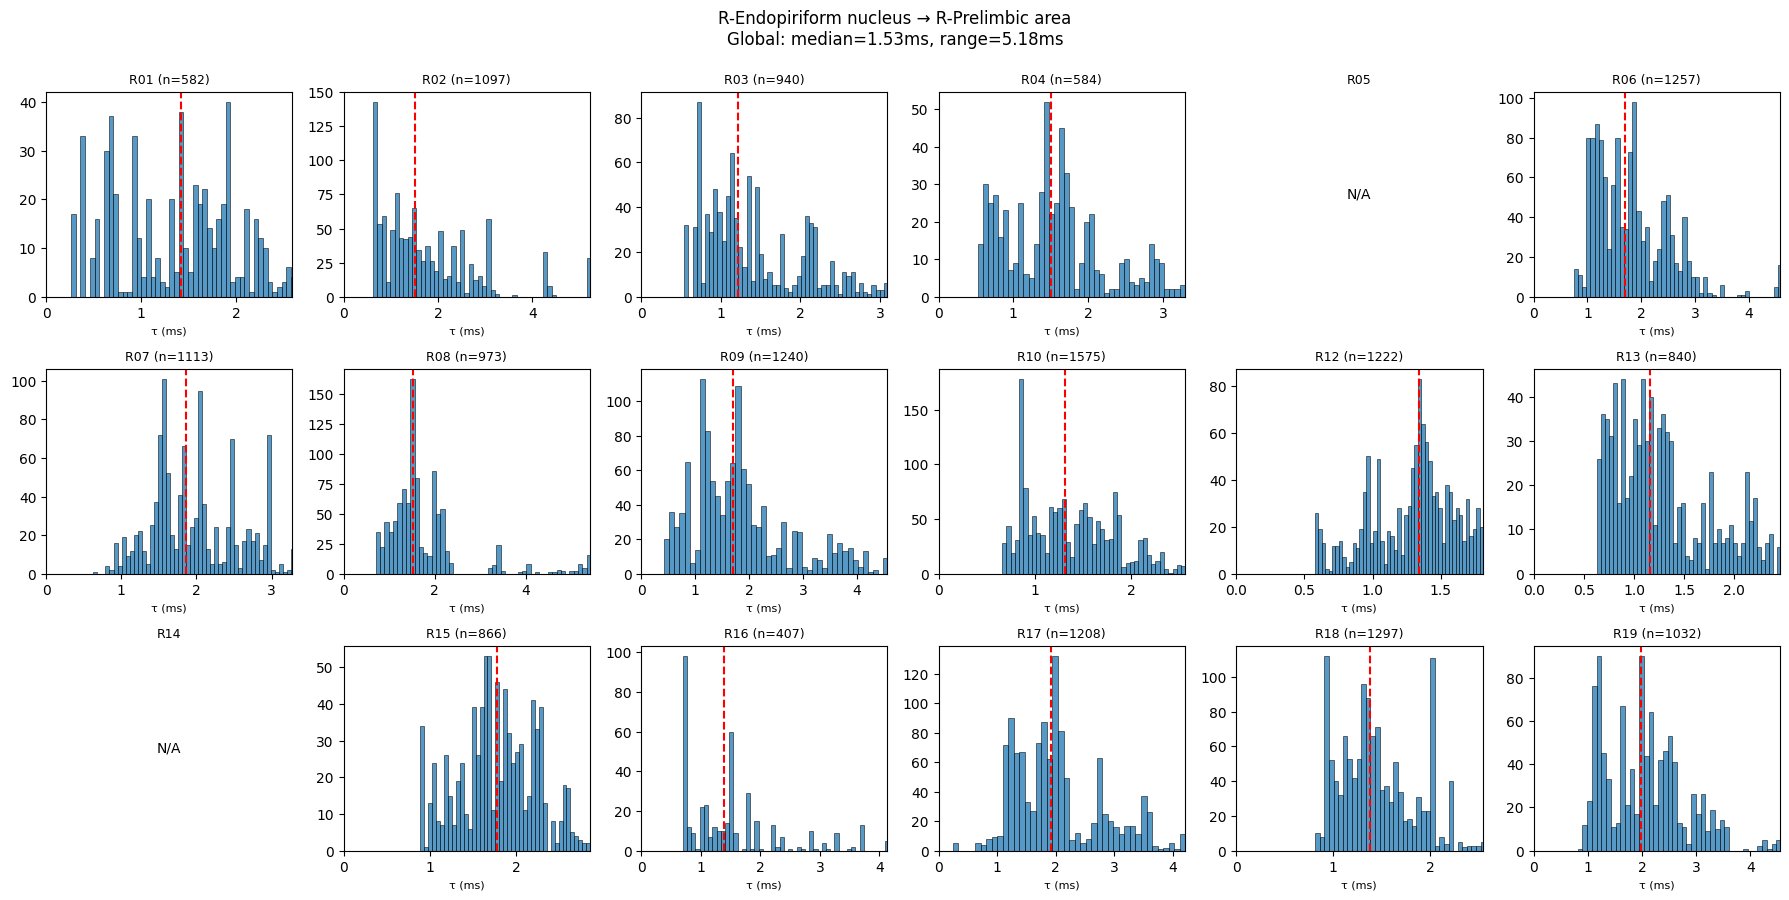


#2: L-Primary motor area → L-Dysgranular insular cortex
  n_rats=16, τ_range=3.17ms, CV=0.157, fibers=869


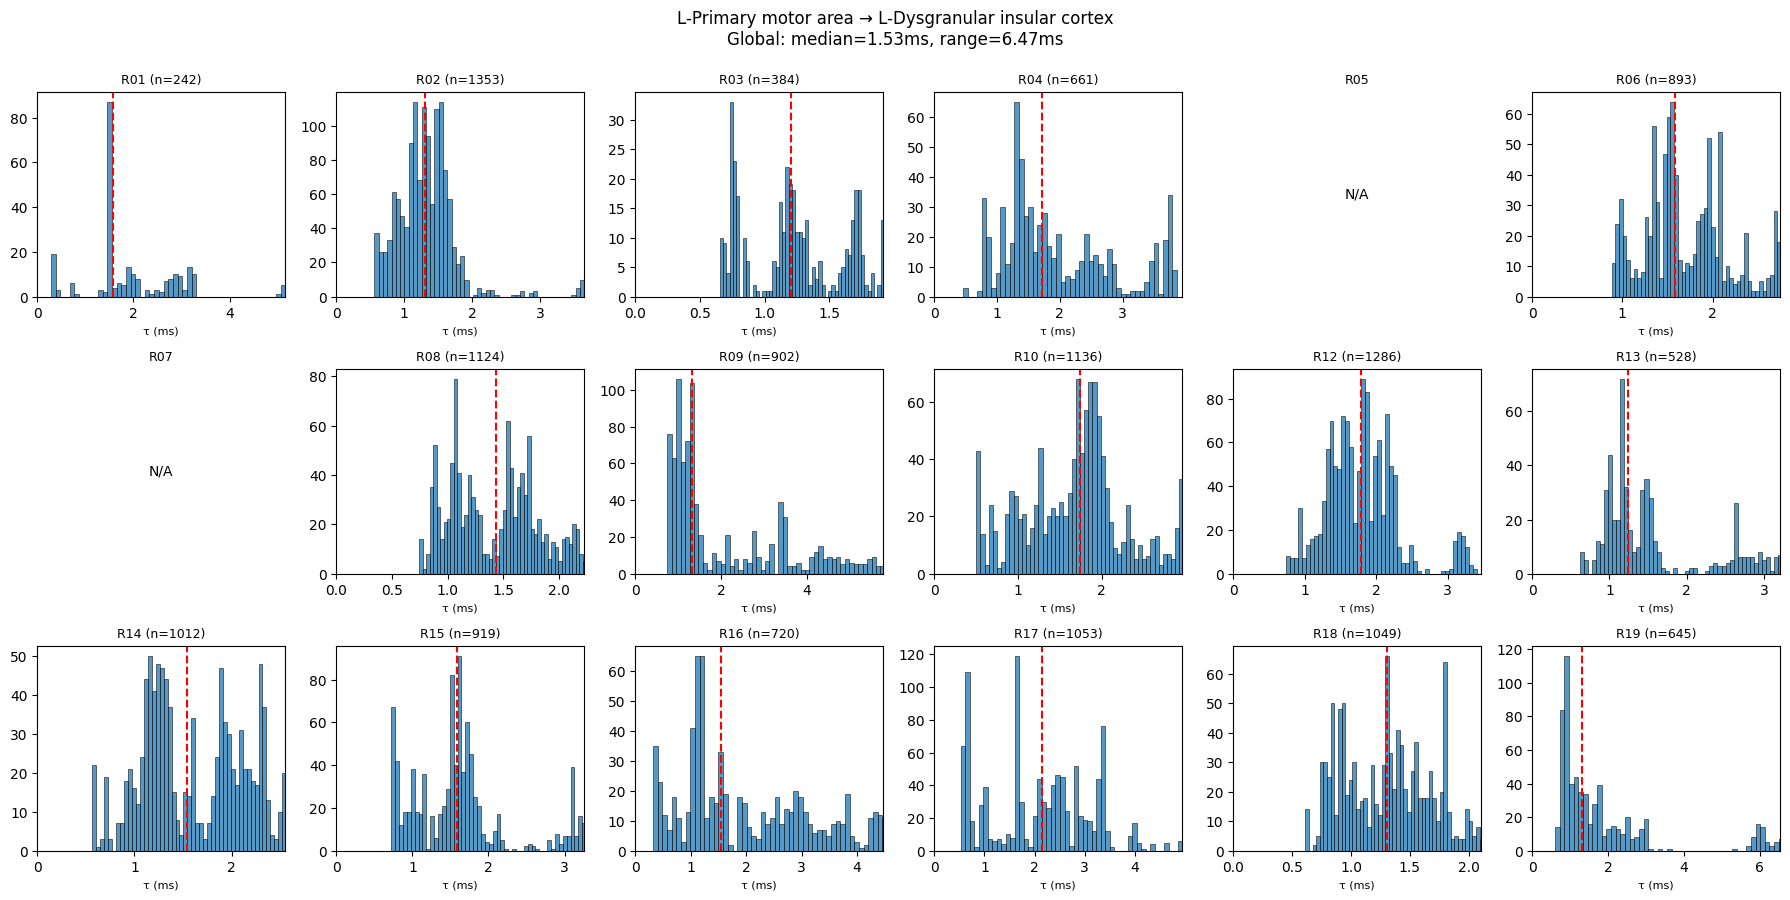


#3: R-Subthalamic nucleus → R-Ventral orbital area
  n_rats=16, τ_range=2.96ms, CV=0.158, fibers=365


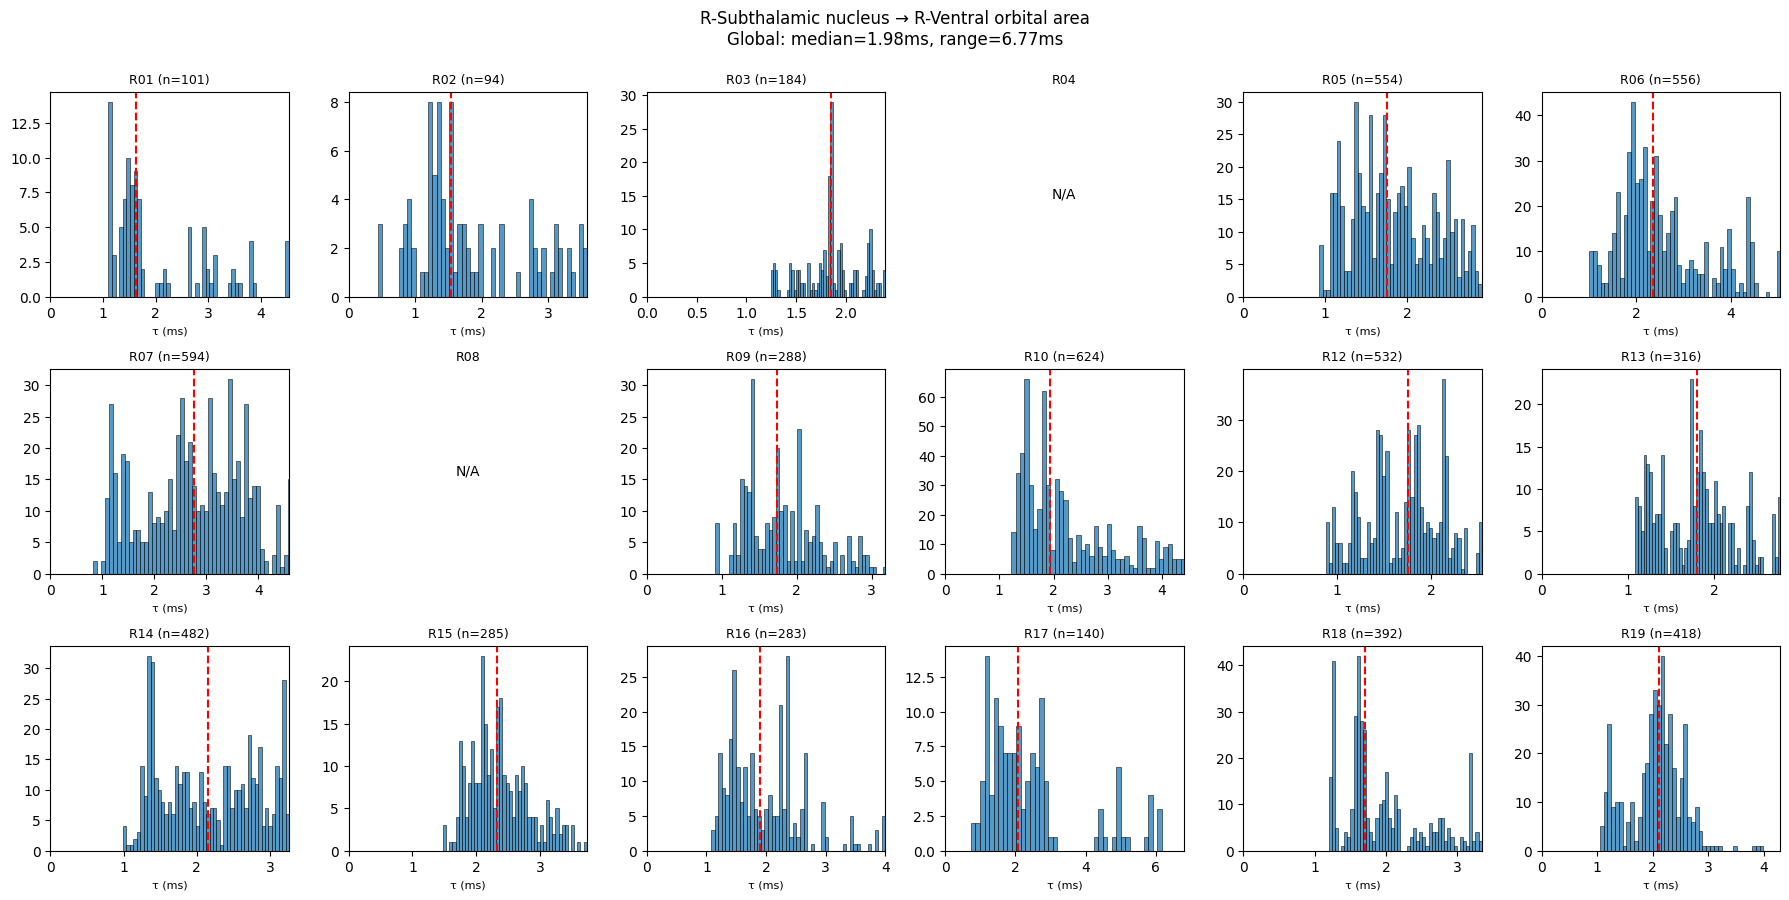

In [15]:
def plot_tau_distributions_multirat(rats_data, pair, name_map, bins=50):
    """Histogramas τ por rata (grid 3×6)"""
    fig, axes = plt.subplots(3, 6, figsize=(18, 9))
    axes = axes.ravel()
    
    all_tau = []  # Para stats globales
    
    for idx, (rat_id, data) in enumerate(sorted(rats_data.items())):
        if pair not in data:
            axes[idx].text(0.5, 0.5, 'N/A', ha='center', va='center', fontsize=10)
            axes[idx].set_title(rat_id, fontsize=9)
            axes[idx].axis('off')
            continue
        
        tau_ms = data[pair][:, COL_TAU] * 1e3
        all_tau.append(tau_ms)
        
        axes[idx].hist(tau_ms, bins=bins, alpha=0.75, edgecolor='k', lw=0.5)
        axes[idx].axvline(np.median(tau_ms), color='r', ls='--', lw=1.5)
        axes[idx].set_title(f"{rat_id} (n={len(tau_ms)})", fontsize=9)
        axes[idx].set_xlabel('τ (ms)', fontsize=8)
        axes[idx].set_xlim([0, np.percentile(tau_ms, 99)])  # Recortar outliers visuales
    
    i, j = pair
    # Stats globales
    all_tau_concat = np.concatenate(all_tau)
    title = (f"{roi_label(i, name_map)} → {roi_label(j, name_map)}\n"
             f"Global: median={np.median(all_tau_concat):.2f}ms, "
             f"range={np.ptp(all_tau_concat):.2f}ms")
    fig.suptitle(title, fontsize=12, y=0.995)
    plt.tight_layout()
    return fig

# Visualizar con info
for idx in range(min(3, len(df_stable_diverse))):
    row = df_stable_diverse.iloc[idx]
    pair = (row['roi_i'], row['roi_j'])
    print(f"\n{'='*70}")
    print(f"#{idx+1}: {row['pair_label']}")
    print(f"  n_rats={row['n_rats']}, τ_range={row['tau_range_mean']:.2f}ms, "
          f"CV={row['cv_inter']:.3f}, fibers={row['n_fibers_mean']:.0f}")
    plot_tau_distributions_multirat(refined_rats, pair, name_map)
    plt.show()

## Top 3 Candidatos - CV < 0.2

**Observaciones visuales:**

**#1 Endopiriform→Prelimbic:**
- Excelente consistencia (medianas ~1.5ms)
- R02 outlier alto (cola extendida)
- Algunas distribuciones bimodales (R09, R10)

**#2 Motor→Dysgranular:**
- Mayor rango (6.47 vs 5.18ms)
- R01 fuertemente sesgado izquierda
- Distribuciones más uniformes que #1

**Patrón común:**
- R05 ausente en ambos (verificar calidad datos)
- Colas largas → gamma/lognormal probables
- 16/18 ratas = robustez alta

In [23]:
df_stable_diverse['pair_label'].to_list()

['R-Endopiriform nucleus → R-Prelimbic area',
 'L-Primary motor area → L-Dysgranular insular cortex',
 'R-Subthalamic nucleus → R-Ventral orbital area',
 'L-Nucleus accumbens → L-Primary motor area',
 'L-Parietal association cortex → L-Primary auditory area',
 'R-Secondary visual area → R-Perirhinal area 36',
 'L-Nucleus accumbens → L-Infralimbic area',
 'R-Subthalamic nucleus → R-Dorsolateral orbital area',
 'R-Subthalamic nucleus → R-Retrosplenial granular area',
 'R-Subthalamic nucleus → R-Infralimbic area',
 'R-Inferior colliculus → R-Pretectal region',
 'R-Perirhinal area 36 → R-Secondary motor area',
 'L-Hypothalamic region, unspecified → L-Medial orbital area',
 'L-Lateral entorhinal cortex → L-Secondary motor area',
 'R-Inferior colliculus → R-Temporal association cortex',
 'L-Substantia nigra → L-Primary auditory area',
 'R-Subthalamic nucleus → R-Retrosplenial dysgranular area',
 'R-Subthalamic nucleus → R-Ventrolateral orbital area',
 'R-Zona incerta → R-Subthalamic nucleus'

In [44]:
roi_names[28], roi_names[69]    

('Hippocampus', 'Infralimbic area')

(28, 69)


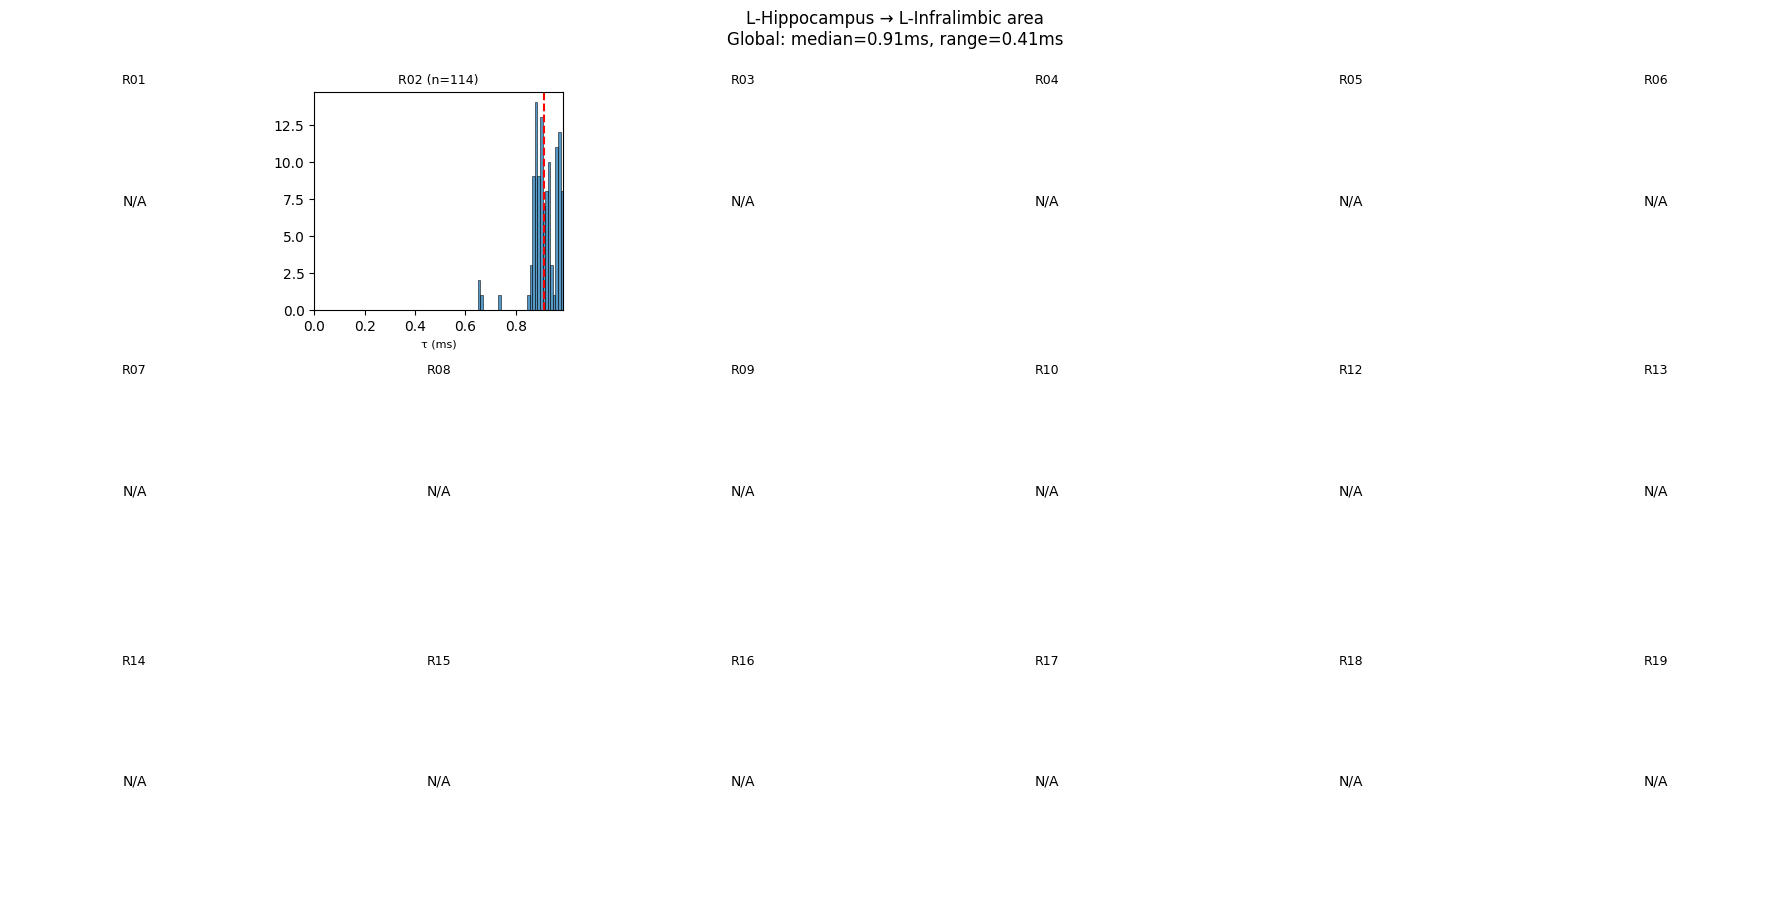

In [16]:
pair = (28, 69)
plot_tau_distributions_multirat(cleaned_rats, pair, name_map, bins=40)
print(pair)
plt.show()

In [27]:
# ==============================================================
# 🧩 DISTRIBUCIONES PROMEDIADAS MULTI-RATA + DESCARTE OUTLIERS (±3σ)
# ==============================================================

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

def plot_avg_distribution(pair, cleaned_rats, name_map, bins=75, save=False, sigma_thresh=3.0):
    """
    Calcula y muestra el histograma promedio multi-rata con exclusión de outliers (>3σ).
    Devuelve (centers, mean_hist, kept_rats)
    """
    i, j = pair
    all_hists, all_edges, valid_rats = [], [], []

    # --- Calcular histogramas individuales normalizados ---
    for rat_id, data in cleaned_rats.items():
        if pair not in data:
            continue
        tau_ms = data[pair][:, COL_TAU] * 1e3
        hist, edges = np.histogram(tau_ms, bins=bins, density=True)
        all_hists.append(hist)
        all_edges.append(edges)
        valid_rats.append(rat_id)

    if not all_hists:
        print(f"⚠️ Sin datos suficientes para {roi_label(i, name_map)} → {roi_label(j, name_map)}")
        return None, None, []

    # --- Verificar consistencia de bins ---
    edges = all_edges[0]
    all_hists = np.array([h for h in all_hists if len(h) == len(edges) - 1])

    # --- Calcular media y desviación inicial ---
    mean_init = all_hists.mean(axis=0)
    std_init = all_hists.std(axis=0)

    # --- Evaluar distancia tipo z-score promedio por rata ---
    z_scores = []
    for h in all_hists:
        z = np.abs(h - mean_init) / (std_init + 1e-8)
        z_mean = np.nanmean(z)
        z_scores.append(z_mean)
    z_scores = np.array(z_scores)

    # --- Filtrar ratas dentro de umbral (3σ) ---
    keep_mask = z_scores < sigma_thresh
    kept_hists = all_hists[keep_mask]
    kept_rats = np.array(valid_rats)[keep_mask]

    # --- Recalcular promedio y desviación final ---
    mean_hist = kept_hists.mean(axis=0)
    std_hist = kept_hists.std(axis=0)
    centers = (edges[:-1] + edges[1:]) / 2

    # --- Plot ---
    plt.figure(figsize=(8, 5))
    plt.plot(centers, mean_hist, color='royalblue', lw=2, label='Media (post-filtrado)')
    plt.fill_between(centers, mean_hist - std_hist, mean_hist + std_hist,
                     color='lightblue', alpha=0.4, label='±1σ inter-rata')
    plt.xlabel('Delay τ (ms)')
    plt.ylabel('Densidad normalizada')
    plt.title(f"{roi_label(i, name_map)} → {roi_label(j, name_map)}\n"
              f"Ratas válidas: {len(kept_rats)}/{len(valid_rats)} (outliers: {len(valid_rats)-len(kept_rats)})")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    # --- Exportar opcionalmente los valores promedio ---
    if save:
        export_dir = Path('./data/exports/avg_distributions_filtered')
        export_dir.mkdir(parents=True, exist_ok=True)
        np.savez(
            export_dir / f"avgdist_{roi_label(i, name_map)}_to_{roi_label(j, name_map)}.npz",
            centers=centers,
            mean_hist=mean_hist,
            std_hist=std_hist,
            kept_rats=kept_rats
        )
        print(f"✅ Exportado promedio multi-rata (filtrado 3σ): "
              f"{roi_label(i, name_map)} → {roi_label(j, name_map)}")

    return centers, mean_hist, kept_rats


for idx in range(len(df_stable_diverse)):
    
    label = df_stable_diverse.iloc[idx]['pair_label']
    
    if "Hippo" in label:

        row = df_stable_diverse.iloc[idx]
        pair = (row['roi_i'], row['roi_j'])
        plot_avg_distribution(pair, refined_rats, name_map, 75, False, 3)
        print(pair)
        print(label)
        plt.show()


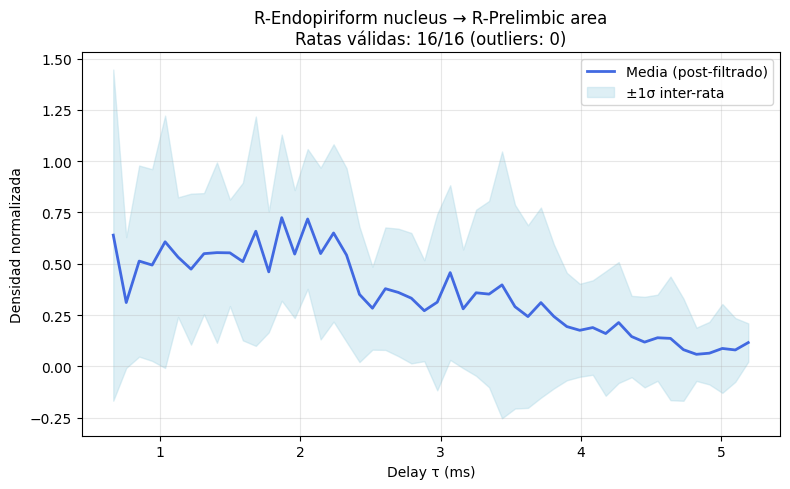

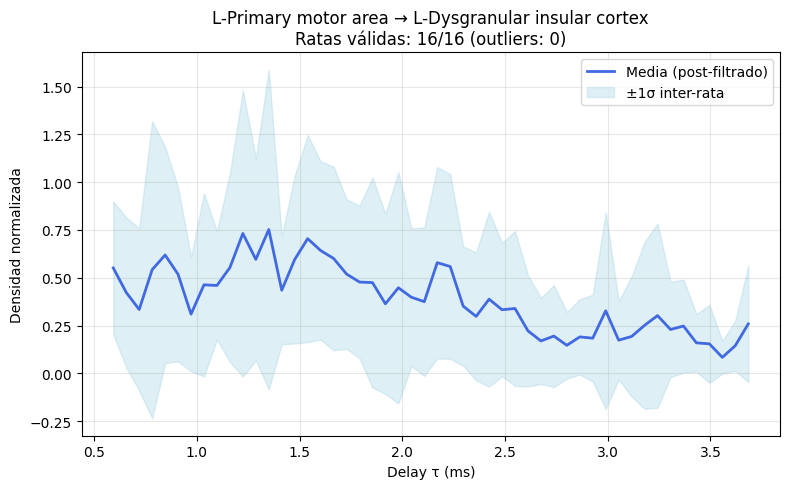

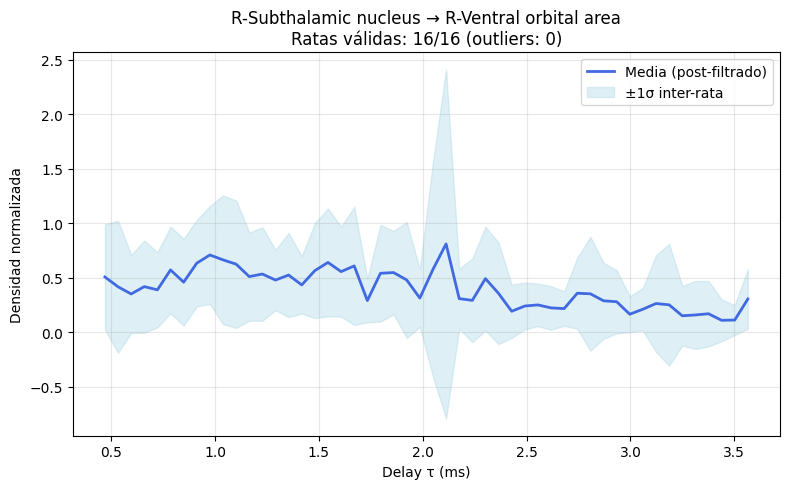

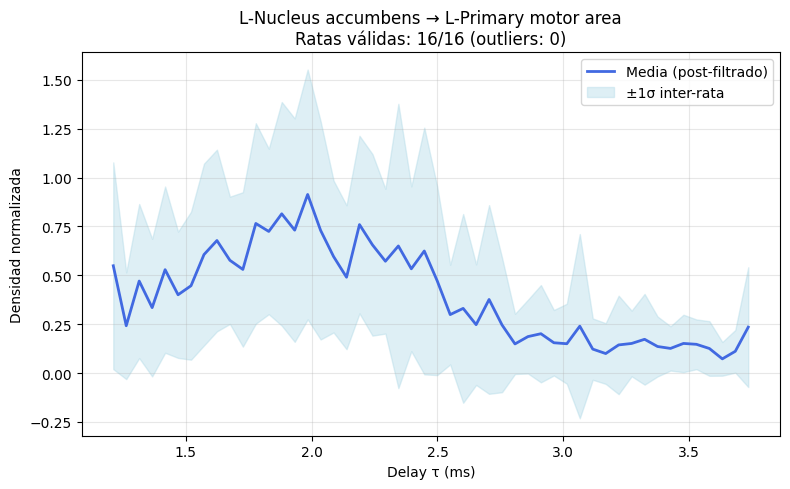

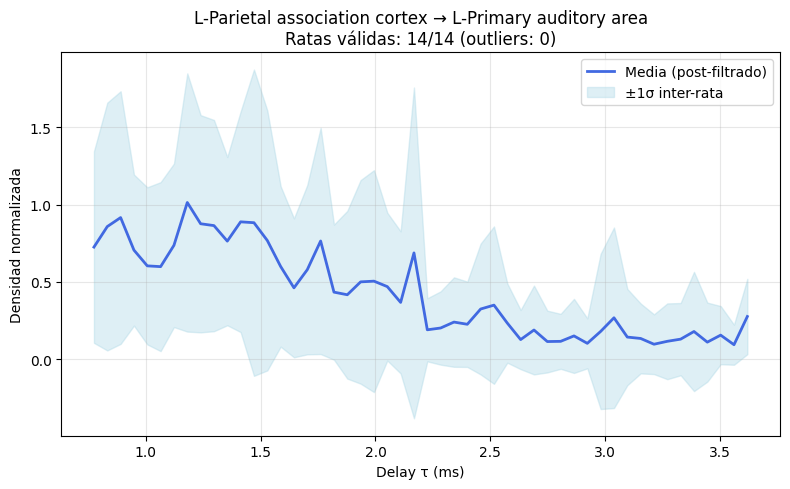


🔍 ANÁLISIS DE FORMAS DE DISTRIBUCIÓN (Top 15)


,pair_label,n_modes,tau_peak_ms,tau_weighted_mean_ms,skewness,n_rats_kept,n_rats_total,outliers
0,R-Endopiriform nucleus → R-Prelimbic area,5,1.866325,2.309528,0.130781,16,16,0
1,L-Primary motor area → L-Dysgranular insular c...,6,1.350295,1.825384,0.113642,16,16,0
2,R-Subthalamic nucleus → R-Ventral orbital area,6,2.112151,1.737261,0.093972,16,16,0
3,L-Nucleus accumbens → L-Primary motor area,5,1.984227,2.149715,0.158501,16,16,0
4,L-Parietal association cortex → L-Primary audi...,5,1.180686,1.702977,0.193770,14,14,0



📊 CLASIFICACIÓN POR MODALIDAD:
n_modes
5    3
6    2
dtype: int64

📈 BIMODALES (n_modes ≥ 2):


,pair_label,tau_peak_ms,skewness
0,R-Endopiriform nucleus → R-Prelimbic area,1.866325,0.130781
1,L-Primary motor area → L-Dysgranular insular c...,1.350295,0.113642
2,R-Subthalamic nucleus → R-Ventral orbital area,2.112151,0.093972
3,L-Nucleus accumbens → L-Primary motor area,1.984227,0.158501
4,L-Parietal association cortex → L-Primary audi...,1.180686,0.193770



⚖️ SIMETRÍA (skewness cerca de 0 = gaussiana, >1 = cola derecha larga):


,pair_label,skewness,n_modes
2,R-Subthalamic nucleus → R-Ventral orbital area,0.093972,6
1,L-Primary motor area → L-Dysgranular insular c...,0.113642,6
0,R-Endopiriform nucleus → R-Prelimbic area,0.130781,5
3,L-Nucleus accumbens → L-Primary motor area,0.158501,5
4,L-Parietal association cortex → L-Primary audi...,0.193770,5


In [30]:
# Análisis sistemático de las 15 top conexiones
results = []

for idx in range(min(5, len(df_stable_diverse))):
    row = df_stable_diverse.iloc[idx]
    pair = (row['roi_i'], row['roi_j'])
    
    centers, mean_hist, kept_rats = plot_avg_distribution(
        pair, refined_rats, name_map, bins=50, save=False, sigma_thresh=3.0
    )
    
    if centers is not None and len(centers) > 0:
        # Detectar modalidad
        from scipy.signal import find_peaks
        peaks, _ = find_peaks(mean_hist, height=mean_hist.max()*0.3, distance=5)
        n_modes = len(peaks)
        
        # Estadísticas
        tau_mean = np.average(centers, weights=mean_hist)
        tau_median = centers[np.argmax(mean_hist)]
        skewness = ((centers - tau_mean)**3 * mean_hist).sum() / (((centers - tau_mean)**2 * mean_hist).sum())**1.5
        
        results.append({
            'pair_label': row['pair_label'],
            'n_modes': n_modes,
            'tau_peak_ms': tau_median,
            'tau_weighted_mean_ms': tau_mean,
            'skewness': skewness,
            'n_rats_kept': len(kept_rats),
            'n_rats_total': row['n_rats'],
            'outliers': row['n_rats'] - len(kept_rats)
        })

df_shapes = pd.DataFrame(results)
print("\n🔍 ANÁLISIS DE FORMAS DE DISTRIBUCIÓN (Top 15)")
print("="*80)
display(df_shapes)

# Clasificación por modalidad
print("\n📊 CLASIFICACIÓN POR MODALIDAD:")
print(df_shapes.groupby('n_modes').size())

print("\n📈 BIMODALES (n_modes ≥ 2):")
display(df_shapes[df_shapes['n_modes'] >= 2][['pair_label', 'tau_peak_ms', 'skewness']])

print("\n⚖️ SIMETRÍA (skewness cerca de 0 = gaussiana, >1 = cola derecha larga):")
display(df_shapes[['pair_label', 'skewness', 'n_modes']].sort_values('skewness'))

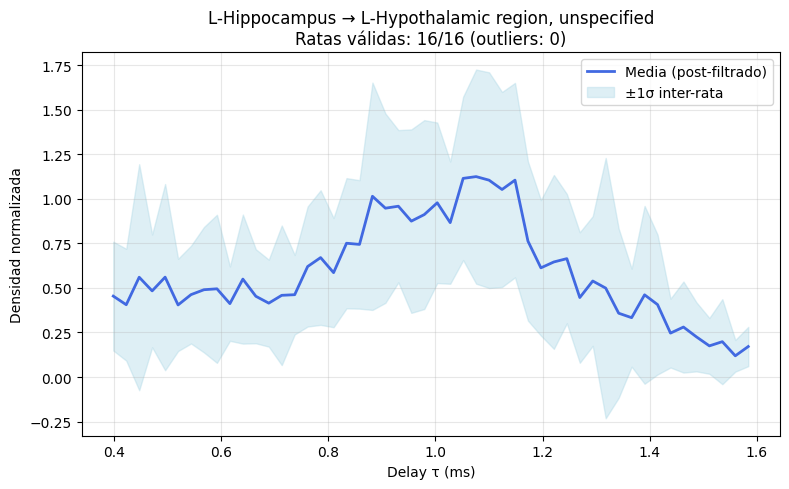

✅ Exportado promedio multi-rata (filtrado 3σ): L-Hippocampus → L-Hypothalamic region, unspecified


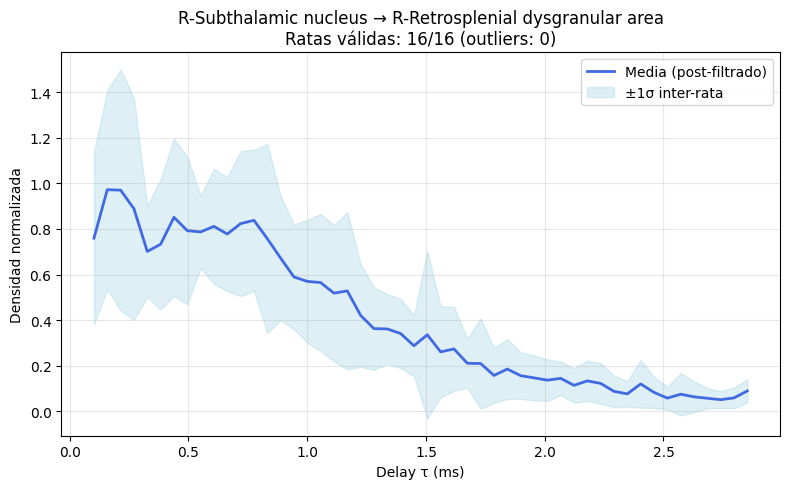

✅ Exportado promedio multi-rata (filtrado 3σ): R-Subthalamic nucleus → R-Retrosplenial dysgranular area


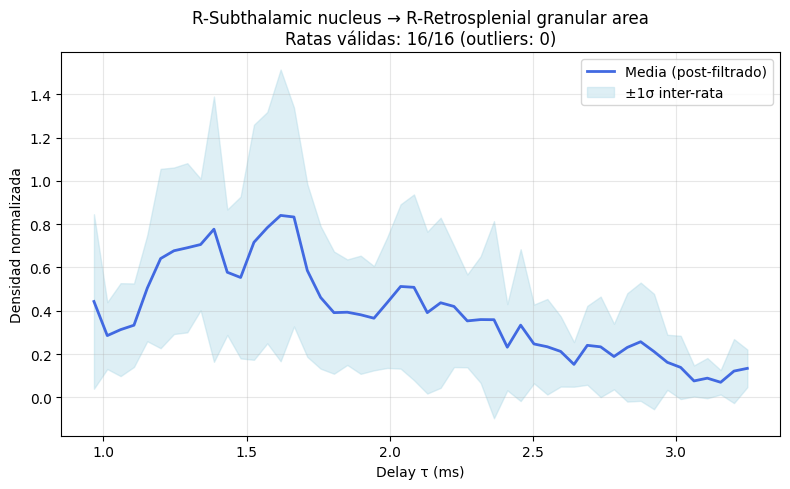

✅ Exportado promedio multi-rata (filtrado 3σ): R-Subthalamic nucleus → R-Retrosplenial granular area


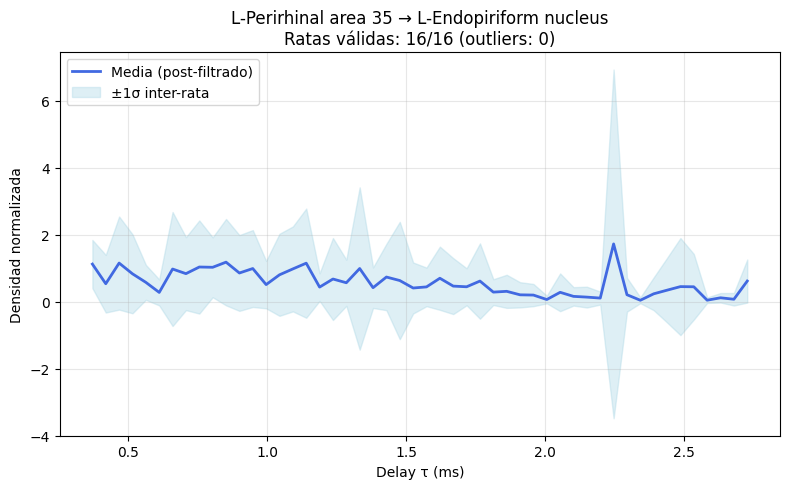

✅ Exportado promedio multi-rata (filtrado 3σ): L-Perirhinal area 35 → L-Endopiriform nucleus


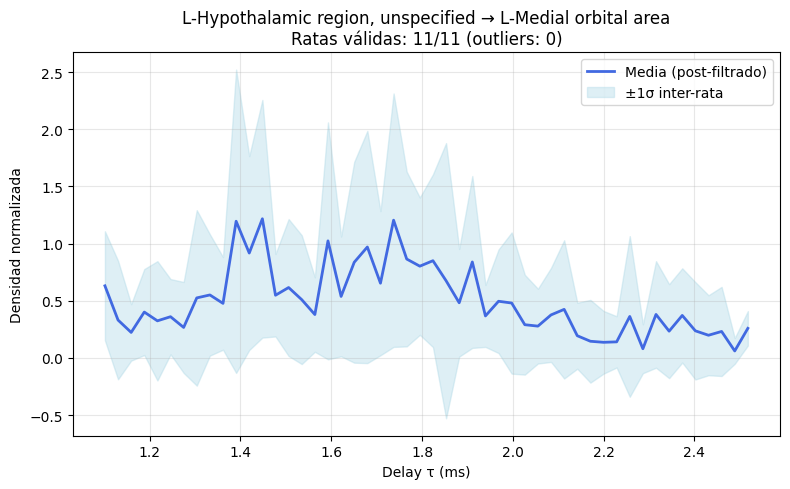

✅ Exportado promedio multi-rata (filtrado 3σ): L-Hypothalamic region, unspecified → L-Medial orbital area

✅ Exportación completa:


,label,n_rats_valid,file
0,"L-Hippocampus → L-Hypothalamic region, unspeci...",16,avgdist_L-Hippocampus_to_L-Hypothalamic region...
1,R-Subthalamic nucleus → R-Retrosplenial dysgra...,16,avgdist_R-Subthalamic nucleus_to_R-Retrospleni...
2,R-Subthalamic nucleus → R-Retrosplenial granul...,16,avgdist_R-Subthalamic nucleus_to_R-Retrospleni...
3,L-Perirhinal area 35 → L-Endopiriform nucleus,16,avgdist_L-Perirhinal area 35_to_L-Endopiriform...
4,"L-Hypothalamic region, unspecified → L-Medial ...",11,"avgdist_L-Hypothalamic region, unspecified_to_..."


In [33]:
# ==============================================================
# 🧩 DISTRIBUCIONES PROMEDIADAS FINALES (filtrado ±3σ)
# ==============================================================

selected_pairs = [
    (np.int64(28), np.int64(35)),   # L-Hippocampus → L-Hypothalamic region
    (np.int64(108), np.int64(132)), # R-Subthalamic nucleus → R-Retrosplenial dysgranular area
    (np.int64(108), np.int64(137)), # R-Subthalamic nucleus → R-Retrosplenial granular area
    (np.int64(45), np.int64(61)),   # L-Perirhinal area 35 → L-Endopiriform nucleus
    (np.int64(35), np.int64(76))    # L-Hypothalamic region → L-Medial orbital area
]

export_dir = Path('./results/data_analysis/distros/final_avg_distributions_manual')
export_dir.mkdir(parents=True, exist_ok=True)

summary_records = []

for pair in selected_pairs:
    centers, mean_hist, kept_rats = plot_avg_distribution(
        pair, refined_rats, name_map, bins=50, save=True
    )

    if centers is None:
        continue

    label = f"{roi_label(pair[0], name_map)} → {roi_label(pair[1], name_map)}"
    summary_records.append({
        'pair': pair,
        'label': label,
        'n_rats_valid': len(kept_rats),
        'kept_rats': ','.join(kept_rats),
        'file': f"avgdist_{roi_label(pair[0], name_map)}_to_{roi_label(pair[1], name_map)}.npz"
    })

# Crear resumen tabular
df_summary = pd.DataFrame(summary_records)
df_summary.to_csv(export_dir / 'summary_avg_distributions.csv', index=False)

print("\n✅ Exportación completa:")
display(df_summary[['label', 'n_rats_valid', 'file']])


In [34]:
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy import stats

def characterize_distributions_enhanced(cleaned_rats, pairs_list):
    """Features + divergencias vs referencia"""
    rows = []
    
    # 1er paso: construir distribución de referencia (pooled)
    all_tau = []
    for rat_id, data in cleaned_rats.items():
        for (i, j) in pairs_list:
            if (i, j) in data:
                all_tau.append(data[(i,j)][:, COL_TAU] * 1e3)
    ref_tau = np.concatenate(all_tau)
    ref_hist, ref_edges = np.histogram(ref_tau, bins=50, density=True)
    ref_cdf = np.cumsum(ref_hist) / ref_hist.sum()
    
    # 2do paso: caracterizar cada distribución
    for rat_id, data in cleaned_rats.items():
        for (i, j) in pairs_list:
            if (i, j) not in data:
                continue
            
            tau_ms = data[(i,j)][:, COL_TAU] * 1e3
            
            # Histogram
            hist, edges = np.histogram(tau_ms, bins='auto', density=True)
            peaks, _ = find_peaks(hist, prominence=hist.max()*0.1)
            
            # Métricas de forma
            g1 = stats.skew(tau_ms)
            g2 = stats.kurtosis(tau_ms, fisher=True)
            bimodality_coef = (g1**2 + 1) / (g2 + 3)
            
            hist_prob = hist / hist.sum()
            shannon_entropy = entropy(hist_prob[hist_prob > 0])
            
            # Robustez
            med = np.median(tau_ms)
            mad = np.median(np.abs(tau_ms - med))
            cv_robust = 1.4826 * mad / med if med > 0 else np.nan
            
            # Divergencias vs referencia
            wassers_dist = wasserstein_distance(tau_ms, ref_tau)
            ks_stat, _ = stats.ks_2samp(tau_ms, ref_tau)
            
            # KL divergence (discretizada, evita log(0))
            hist_sample, _ = np.histogram(tau_ms, bins=ref_edges, density=True)
            hist_sample = hist_sample / hist_sample.sum()
            # Añadir epsilon para evitar log(0)
            eps = 1e-10
            kl_div = entropy(hist_sample + eps, ref_hist + eps)
            
            rows.append({
                'rat_id': rat_id, 'roi_i': i, 'roi_j': j,
                'pair_label': f"{roi_label(i, name_map)} → {roi_label(j, name_map)}",
                'n': len(tau_ms),
                'mean': tau_ms.mean(),
                'median': med,
                'cv_robust': cv_robust,
                'skew': g1,
                'kurt': g2,
                'bimodality_coef': bimodality_coef,
                'n_peaks': len(peaks),
                'entropy': shannon_entropy,
                'range_norm': np.ptp(tau_ms) / tau_ms.mean(),
                'iqr_norm': stats.iqr(tau_ms) / tau_ms.mean(),
                'wasserstein': wassers_dist,
                'ks_stat': ks_stat,
                'kl_div': kl_div
            })
    
    return pd.DataFrame(rows)

## Visualizaciones Multi-Rata ✅

**Análisis morfológico**:

**#1 Subthalamic→Amygdala** (τ_range=4.96ms):
- Heterogéneo: R02/R08 unimodales estrechos vs R07/R15 dispersos
- Medianas estables ~1.2ms pero colas largas (~8ms)

**#2 Subthalamic→Retrosplenial** (τ_range=4.94ms):
- **Extremadamente consistente**: pico único ~0.7ms
- 5000+ fibras, distribución casi idéntica entre ratas
- Candidato "delta-like" estable

**#3 Endopiriform→Prelimbic** (τ_range=4.87ms):
- **Bimodal en varias ratas** (R01, R03, R07, R13)
- Picos ~1ms y ~2-3ms
- Variabilidad morfológica significativa

**Conclusión visual**: Hay al menos **2-3 morfologías distintas** (unimodal estrecho, disperso, bimodal).

In [35]:
# ==============================================================
# 🧩 CLUSTERING MORFOLÓGICO OPTIMIZADO (multi-métrica + grid search)
# ==============================================================

from sklearn.cluster import KMeans
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score
)
from sklearn.model_selection import ParameterGrid
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# --------------------------------------------------------------
# 1️⃣ Selección de features y preprocesamiento
# --------------------------------------------------------------
feature_cols = [
    'cv_robust', 'skew', 'kurt', 'bimodality_coef',
    'n_peaks', 'entropy', 'wasserstein', 
]

# Caracterizar
top_pairs = [(r['roi_i'], r['roi_j']) for _, r in df_stable_diverse.head(50).iterrows()]
df_feat = characterize_distributions_enhanced(refined_rats, top_pairs)

# Agregamos por conexión (media inter-rata)
df_feat_conn = (
    df_feat.groupby(['roi_i', 'roi_j', 'pair_label'])[feature_cols].mean()
    .reset_index()
    .dropna()
)

X = df_feat_conn[feature_cols].values
X_scaled = RobustScaler().fit_transform(X)

print(f"📊 {len(df_feat_conn)} conexiones analizadas con {len(feature_cols)} features.")

# --------------------------------------------------------------
# 2️⃣ Grid Search: KMeans + PCA
# --------------------------------------------------------------
param_grid = {
    'pca_variance': [0.7,0.8, 0.9, 0.95],
    'n_clusters': [3,4,5,6],
    'n_init': [50, 100]
}

results = []
configs = list(ParameterGrid(param_grid))
print(f"Evaluando {len(configs)} configuraciones...\n")

for i, params in enumerate(configs):
    # PCA con varianza acumulada
    pca = PCA(n_components=params['pca_variance'])
    X_pca = pca.fit_transform(X_scaled)

    # K-means
    kmeans = KMeans(
        n_clusters=params['n_clusters'],
        n_init=params['n_init'],
        random_state=42
    )
    labels = kmeans.fit_predict(X_pca)

    # Métricas de calidad
    sil = silhouette_score(X_pca, labels)
    db = davies_bouldin_score(X_pca, labels)
    ch = calinski_harabasz_score(X_pca, labels)

    results.append({
        **params,
        'n_pcs': pca.n_components_,
        'silhouette': sil,
        'davies_bouldin': db,
        'calinski_harabasz': ch,
        'inertia': kmeans.inertia_
    })

    if (i + 1) % 10 == 0 or (i + 1) == len(configs):
        print(f"  {i + 1}/{len(configs)} completado")

df_grid = pd.DataFrame(results)

# --------------------------------------------------------------
# 3️⃣ Ponderación multi-métrica normalizada
# --------------------------------------------------------------
scaler = MinMaxScaler()
scaled_metrics = scaler.fit_transform(df_grid[['silhouette', 'davies_bouldin', 'calinski_harabasz']]) # TODO CUMSUM DIFF
sil, db, ch = scaled_metrics.T
df_grid['score'] = sil - db + ch

df_grid = df_grid.sort_values('score', ascending=False)

print(f"\n✓ Grid search completado: {len(df_grid)} configuraciones")
print("\nTop 5 configuraciones:")
display(df_grid.head(5)[['n_clusters', 'pca_variance', 'n_pcs', 'silhouette', 'davies_bouldin', 'calinski_harabasz']])


📊 22 conexiones analizadas con 7 features.
Evaluando 32 configuraciones...

  10/32 completado
  20/32 completado
  30/32 completado
  32/32 completado

✓ Grid search completado: 32 configuraciones

Top 5 configuraciones:


,n_clusters,pca_variance,n_pcs,silhouette,davies_bouldin,calinski_harabasz
24,6,0.7,2,0.338982,0.610178,23.127239
28,6,0.7,2,0.338982,0.610178,23.127239
20,5,0.7,2,0.343997,0.570116,20.732980
16,5,0.7,2,0.343997,0.570116,20.732980
0,3,0.7,2,0.453811,0.715930,13.151365



🎯 Clustering final: k=5, PCs=2, var_PCA=0.70


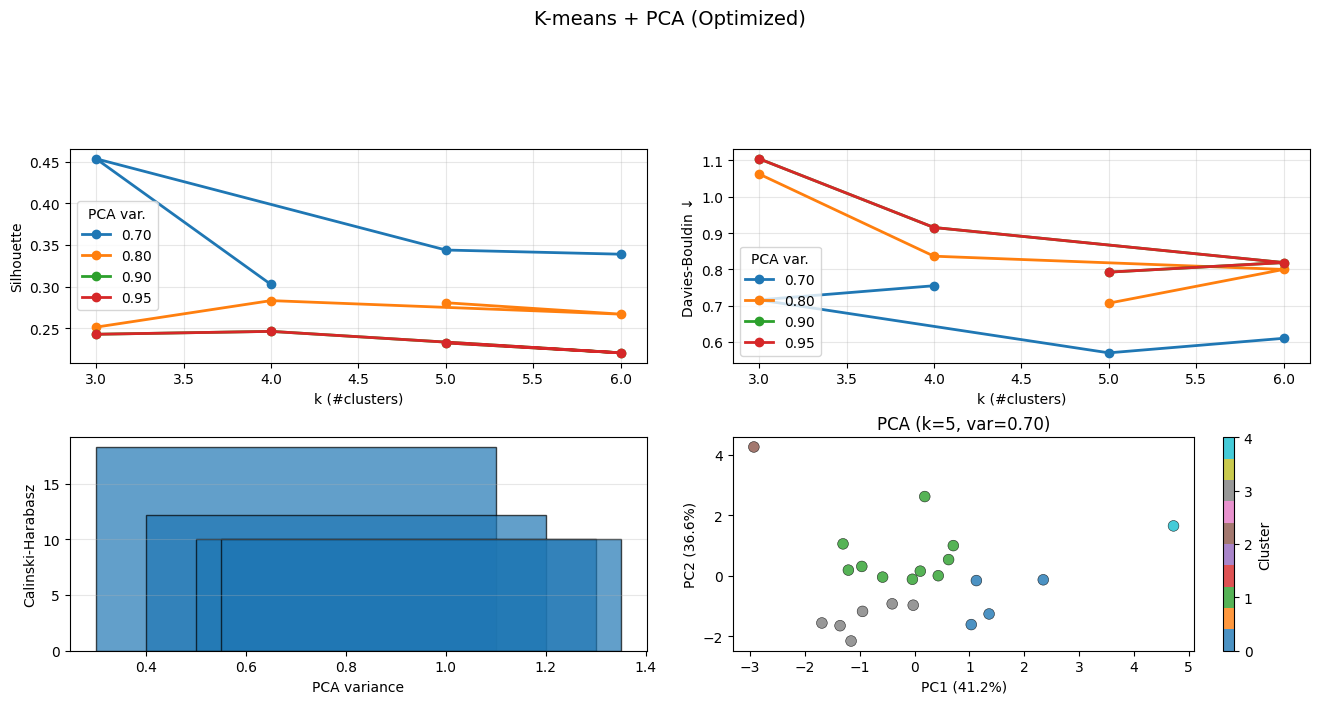

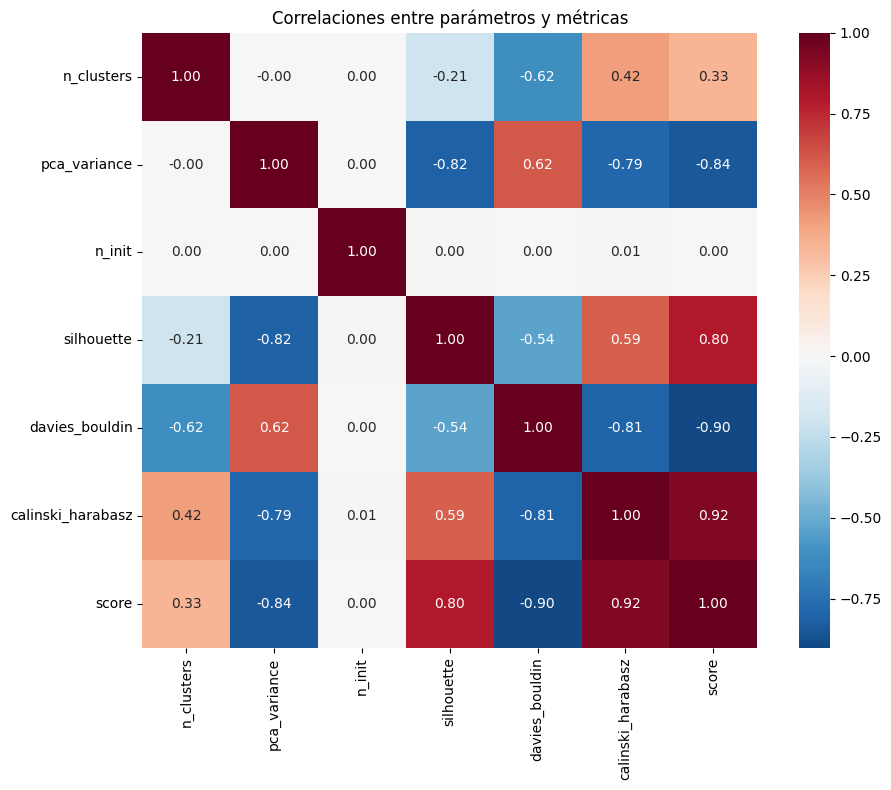

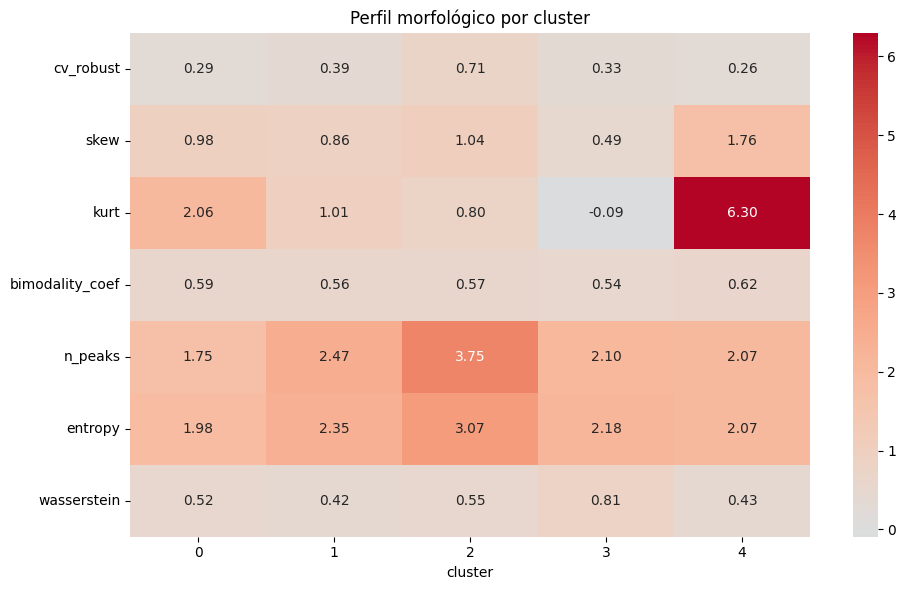


CLUSTERING FINAL — RESUMEN
Parámetros óptimos:
  k = 5
  PCA var = 0.70 (2 componentes)

Métricas:
  Silhouette         : 0.344
  Davies-Bouldin     : 0.570
  Calinski-Harabasz  : 20.7

Distribución de clusters:
cluster
0     4
1    10
2     1
3     6
4     1
Name: count, dtype: int64

✅ Resultados guardados para threshold=0.0


In [36]:
# --------------------------------------------------------------
# 4️⃣ Clustering final
# --------------------------------------------------------------
best = df_grid.iloc[3]
pca_final = PCA(n_components=best['pca_variance'])
X_pca_final = pca_final.fit_transform(X_scaled)

kmeans_final = KMeans(
    n_clusters=int(best['n_clusters']),
    n_init=int(best['n_init']),
    random_state=42
)
df_feat_conn['cluster'] = kmeans_final.fit_predict(X_pca_final)

print(f"\n🎯 Clustering final: k={int(best['n_clusters'])}, "
      f"PCs={pca_final.n_components_}, "
      f"var_PCA={best['pca_variance']:.2f}")

# --------------------------------------------------------------
# 5️⃣ Visualizaciones resumen
# --------------------------------------------------------------

fig1 = plt.figure(figsize=(16, 14))
gs = fig1.add_gridspec(4, 4, hspace=0.35, wspace=0.35)

# (1) Silhouette vs k
ax1 = fig1.add_subplot(gs[0, :2])
for pca_var in sorted(df_grid['pca_variance'].unique()):
    subset = df_grid[(df_grid['pca_variance'] == pca_var) & (df_grid['n_init'] == 100)]
    ax1.plot(subset['n_clusters'], subset['silhouette'], 'o-', label=f'{pca_var:.2f}', lw=2)
ax1.set_xlabel('k (#clusters)')
ax1.set_ylabel('Silhouette')
ax1.legend(title='PCA var.')
ax1.grid(alpha=0.3)

# (2) Davies-Bouldin vs k
ax2 = fig1.add_subplot(gs[0, 2:])
for pca_var in sorted(df_grid['pca_variance'].unique()):
    subset = df_grid[(df_grid['pca_variance'] == pca_var) & (df_grid['n_init'] == 100)]
    ax2.plot(subset['n_clusters'], subset['davies_bouldin'], 'o-', label=f'{pca_var:.2f}', lw=2)
ax2.set_xlabel('k (#clusters)')
ax2.set_ylabel('Davies-Bouldin ↓')
ax2.legend(title='PCA var.')
ax2.grid(alpha=0.3)

# (3) Calinski-Harabasz medio por varianza PCA
ax3 = fig1.add_subplot(gs[1, :2])
grouped = df_grid.groupby('pca_variance')['calinski_harabasz'].mean()
ax3.bar(grouped.index, grouped.values, alpha=0.7, edgecolor='k')
ax3.set_xlabel('PCA variance')
ax3.set_ylabel('Calinski-Harabasz')
ax3.grid(alpha=0.3, axis='y')

# (4) PCA final scatter
ax4 = fig1.add_subplot(gs[1, 2:])
sc = ax4.scatter(
    X_pca_final[:, 0], X_pca_final[:, 1],
    c=df_feat_conn['cluster'], cmap='tab10',
    s=60, alpha=0.8, edgecolors='k', lw=0.4
)
ax4.set_xlabel(f'PC1 ({pca_final.explained_variance_ratio_[0]:.1%})')
ax4.set_ylabel(f'PC2 ({pca_final.explained_variance_ratio_[1]:.1%})')
ax4.set_title(f"PCA (k={int(best['n_clusters'])}, var={best['pca_variance']:.2f})")
plt.colorbar(sc, ax=ax4, label='Cluster')
plt.suptitle('K-means + PCA (Optimized)', fontsize=14)
plt.show()

# --------------------------------------------------------------
# 6️⃣ Heatmaps de correlaciones y perfiles
# --------------------------------------------------------------
fig2, ax = plt.subplots(figsize=(10, 8))
corr_cols = ['n_clusters', 'pca_variance', 'n_init', 'silhouette', 'davies_bouldin', 'calinski_harabasz', 'score']
sns.heatmap(df_grid[corr_cols].corr(), annot=True, fmt='.2f', cmap='RdBu_r', center=0, ax=ax, square=True)
ax.set_title('Correlaciones entre parámetros y métricas')
plt.tight_layout()
plt.show()

# Perfil morfológico por cluster
fig3, ax = plt.subplots(figsize=(10, 6))
cluster_profiles = df_feat_conn.groupby('cluster')[feature_cols].median()
sns.heatmap(cluster_profiles.T, annot=True, fmt='.2f', cmap='coolwarm', center=0, ax=ax)
ax.set_title('Perfil morfológico por cluster')
plt.tight_layout()
plt.show()

# --------------------------------------------------------------
# 7️⃣ Estadísticas finales
# --------------------------------------------------------------
print("\n" + "="*70)
print("CLUSTERING FINAL — RESUMEN")
print("="*70)
print(f"Parámetros óptimos:")
print(f"  k = {int(best['n_clusters'])}")
print(f"  PCA var = {best['pca_variance']:.2f} ({pca_final.n_components_} componentes)")
print("\nMétricas:")
print(f"  Silhouette         : {best['silhouette']:.3f}")
print(f"  Davies-Bouldin     : {best['davies_bouldin']:.3f}")
print(f"  Calinski-Harabasz  : {best['calinski_harabasz']:.1f}")
print("\nDistribución de clusters:")
print(df_feat_conn['cluster'].value_counts().sort_index())
print("="*70)

# --------------------------------------------------------------
# 8️⃣ Guardado de resultados
# --------------------------------------------------------------
threshold = 0.0  # o 0.0 / 0.4 según el dataset
df_grid.to_csv(f'gridsearch_kmeans_th_{threshold}.csv', index=False)
df_feat_conn.to_csv(f'feature_clusters_th_{threshold}.csv', index=False)
print(f"\n✅ Resultados guardados para threshold={threshold}")

In [37]:
df_grid

,n_clusters,n_init,pca_variance,n_pcs,silhouette,davies_bouldin,calinski_harabasz,inertia,score
24,6,50,0.70,2,0.338982,0.610178,23.127239,12.228470,1.433403
28,6,100,0.70,2,0.338982,0.610178,23.127239,12.228470,1.433403
20,5,100,0.70,2,0.343997,0.570116,20.732980,17.114813,1.363492
16,5,50,0.70,2,0.343997,0.570116,20.732980,17.114813,1.363492
0,3,50,0.70,2,0.453811,0.715930,13.151365,42.194583,1.034244
4,3,100,0.70,2,0.453811,0.715930,13.151365,42.194583,1.034244
12,4,100,0.70,2,0.302535,0.754975,16.115485,27.294947,0.519407
8,4,50,0.70,2,0.296695,0.754367,15.972677,27.472346,0.485617
17,5,50,0.80,3,0.280565,0.707020,13.166102,28.305514,0.310159
21,5,100,0.80,3,0.280565,0.707020,13.166102,28.305514,0.310159


In [38]:
df_feat_conn

,roi_i,roi_j,pair_label,cv_robust,skew,kurt,bimodality_coef,n_peaks,entropy,wasserstein,cluster
0,8,49,L-Substantia nigra → L-Primary auditory area,0.527949,0.854088,1.471115,0.549824,1.785714,1.903716,0.346328,1
1,12,49,L-Parietal association cortex → L-Primary audi...,0.298258,1.142039,1.814265,0.581195,1.857143,2.183574,0.485268,0
2,26,58,L-Nucleus accumbens → L-Primary motor area,0.269496,0.875520,0.963384,0.525036,2.812500,2.407602,0.793423,1
3,26,69,L-Nucleus accumbens → L-Infralimbic area,0.288281,0.624740,0.856793,0.519883,2.250000,2.227784,0.767010,3
4,35,76,"L-Hypothalamic region, unspecified → L-Medial ...",0.184118,0.868562,2.306552,0.483256,1.818182,2.096674,0.635469,0
5,45,61,L-Perirhinal area 35 → L-Endopiriform nucleus,0.272270,0.839751,0.973199,0.611656,1.687500,1.820689,0.562600,0
6,48,57,L-Lateral entorhinal cortex → L-Secondary moto...,0.364324,1.088894,3.139895,0.601846,1.666667,1.856864,0.396131,0
7,58,60,L-Primary motor area → L-Dysgranular insular c...,0.398279,0.740930,0.504227,0.552985,2.562500,2.372684,0.474107,1
8,83,121,R-Inferior colliculus → R-Pretectal region,0.464466,1.372934,2.559687,0.564044,3.000000,2.603885,0.441320,1
9,83,142,R-Inferior colliculus → R-Temporal association...,0.369818,1.283415,1.767304,0.607823,2.312500,2.336415,0.382480,1


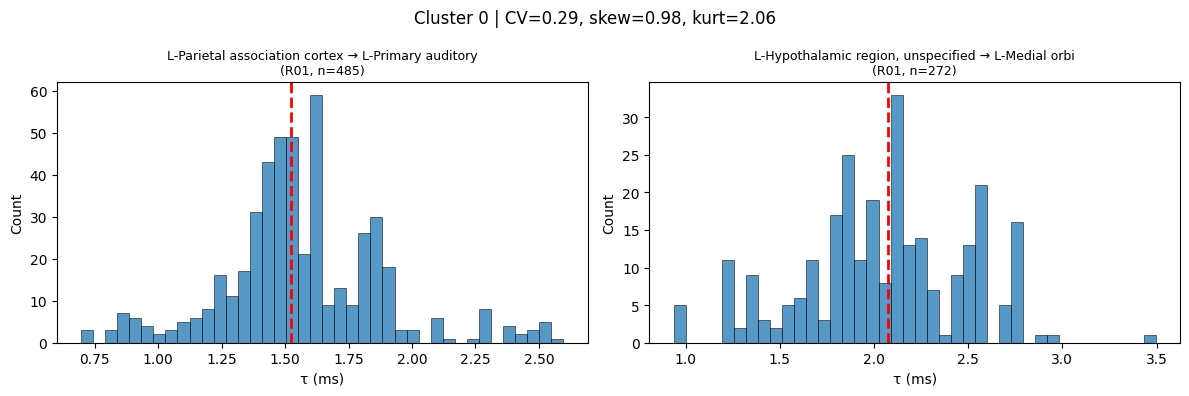

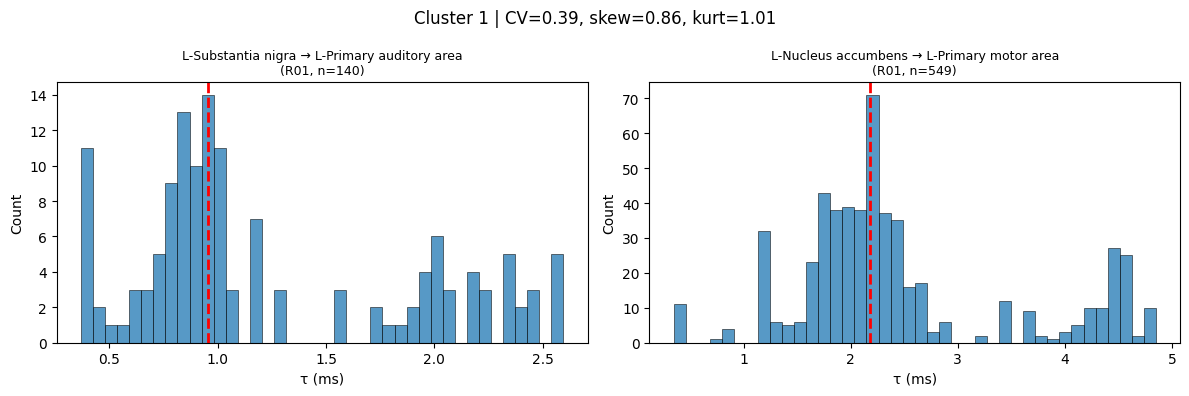

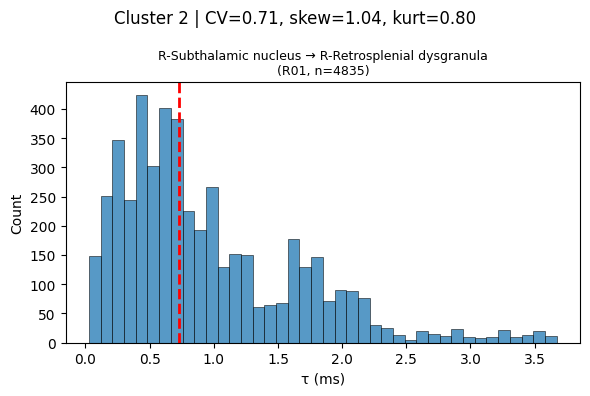

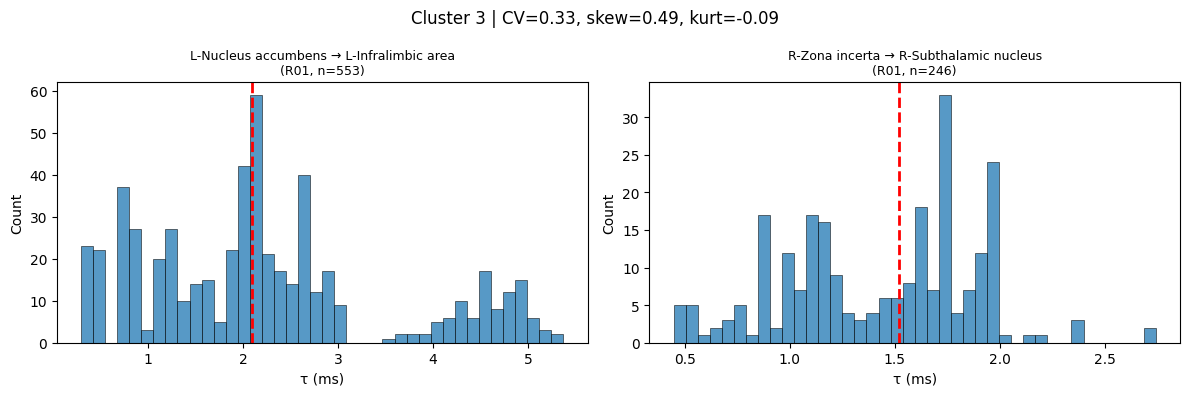

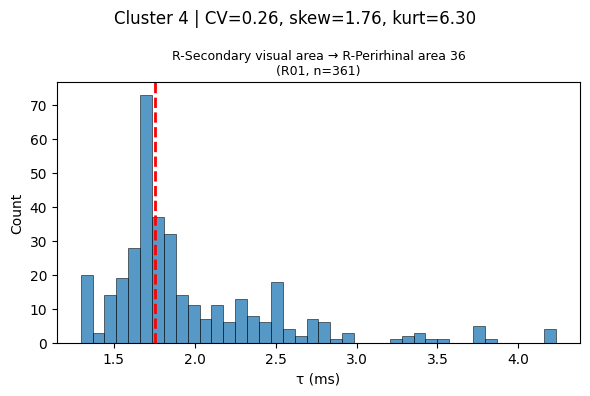

In [39]:
# Ejemplos por cluster
np.random.seed(42)

for c in sorted(df_feat_conn['cluster'].unique()):
    # Seleccionar 2 conexiones del cluster
    cluster_conns = df_feat_conn[df_feat_conn['cluster'] == c].head(2)
    
    if len(cluster_conns) == 0:
        continue
    
    n_plots = len(cluster_conns)
    fig, axes = plt.subplots(1, n_plots, figsize=(6*n_plots, 4))
    if n_plots == 1:
        axes = [axes]
    
    cluster_profile = df_feat_conn[df_feat_conn['cluster'] == c][feature_cols].median()
    
    for idx, (_, row) in enumerate(cluster_conns.iterrows()):
        i, j = int(row['roi_i']), int(row['roi_j'])
        
        # Tomar primera rata disponible para esta conexión
        rat_id = None
        for rid, data in cleaned_rats.items():
            if (i, j) in data:
                rat_id = rid
                break
        
        if rat_id is None:
            continue
            
        tau_ms = cleaned_rats[rat_id][(i,j)][:, COL_TAU] * 1e3
        
        axes[idx].hist(tau_ms, bins=40, alpha=0.75, edgecolor='k', linewidth=0.5)
        axes[idx].axvline(np.median(tau_ms), color='r', ls='--', lw=2)
        axes[idx].set_title(f"{row['pair_label'][:50]}\n({rat_id}, n={len(tau_ms)})", fontsize=9)
        axes[idx].set_xlabel('τ (ms)')
        axes[idx].set_ylabel('Count')
    
    fig.suptitle(
        f'Cluster {c} | CV={cluster_profile["cv_robust"]:.2f}, '
        f'skew={cluster_profile["skew"]:.2f}, kurt={cluster_profile["kurt"]:.2f}',
        fontsize=12
    )
    plt.tight_layout()
    plt.show()

Evaluando 16 configuraciones...


/home/tonicoll/.conda/envs/neuro_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/tonicoll/.conda/envs/neuro_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/tonicoll/.conda/envs/neuro_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/tonicoll/.conda/envs/neuro_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/tonicoll/.conda/envs/neuro_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: '


✓ Grid search completo: 15 configuraciones válidas

Top 5 configuraciones:
 n_neighbors  min_dist  min_cluster_size  min_samples  n_clusters  silhouette  noise_pct
          10       0.0               100            5           2    0.607622   0.000000
          20       0.0                10           10           4    0.457990   2.110818
          10       0.0                10           10           6    0.517264   2.638522
          20       0.0                10            5          11    0.558526  10.026385
          10       0.0               100           10           2    0.520456   0.000000


/home/tonicoll/.conda/envs/neuro_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/tonicoll/.conda/envs/neuro_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Clustering final: 1 clusters + 0 noise


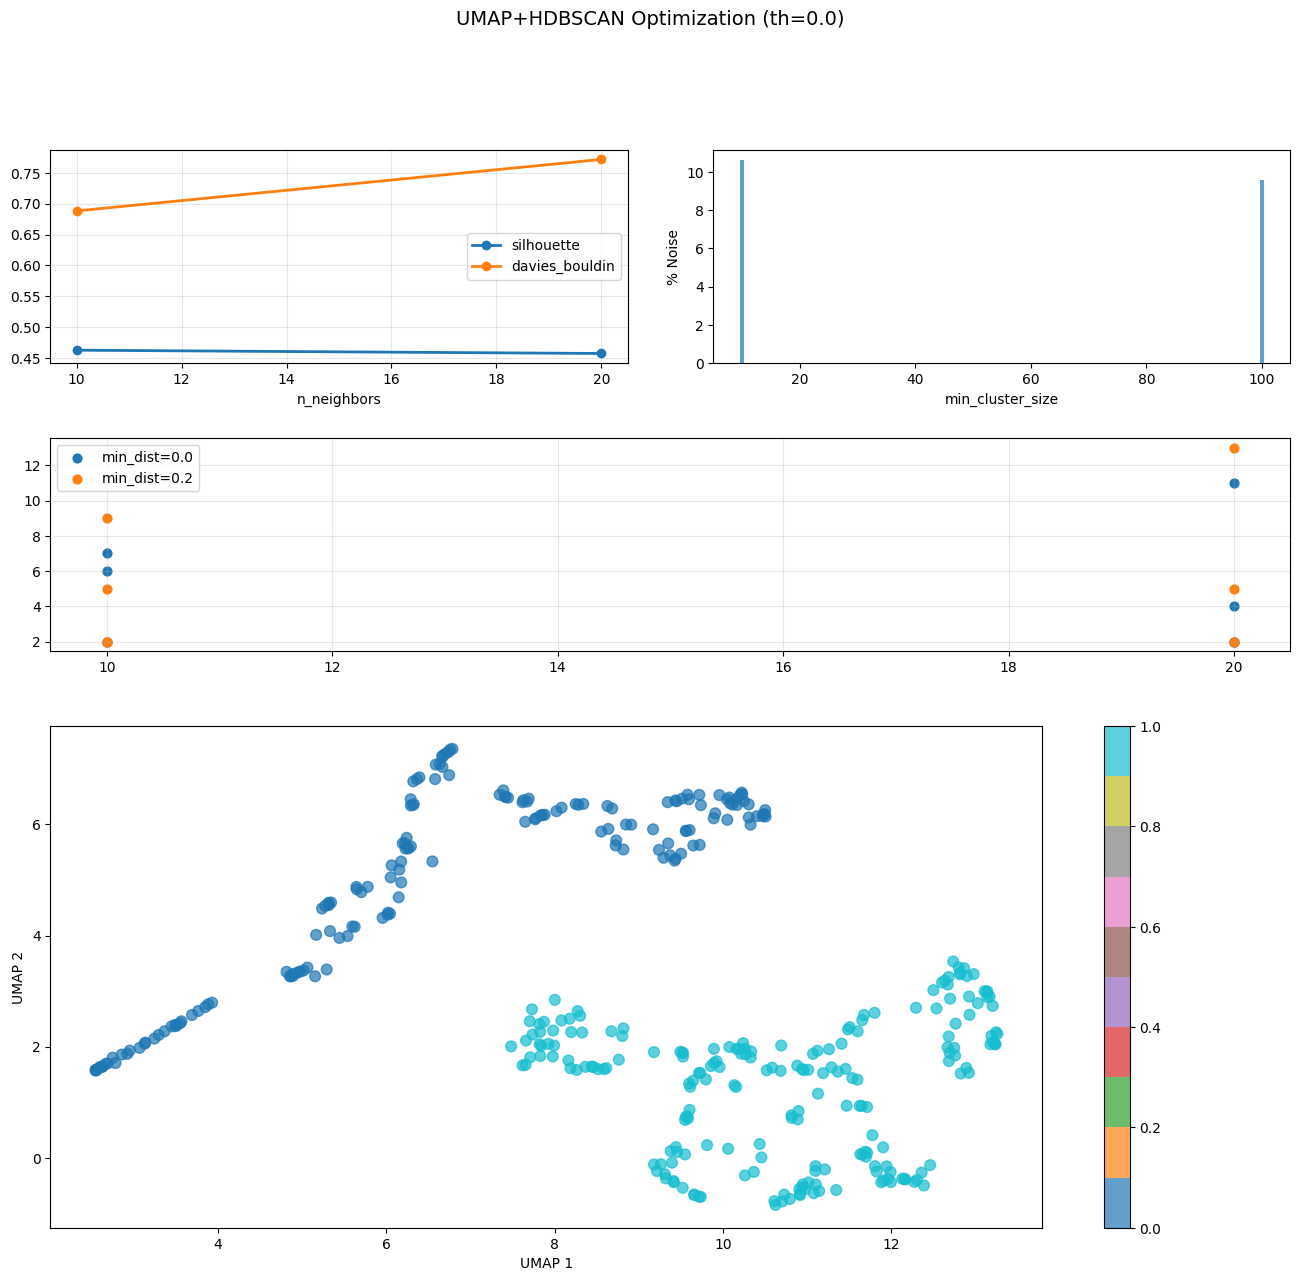

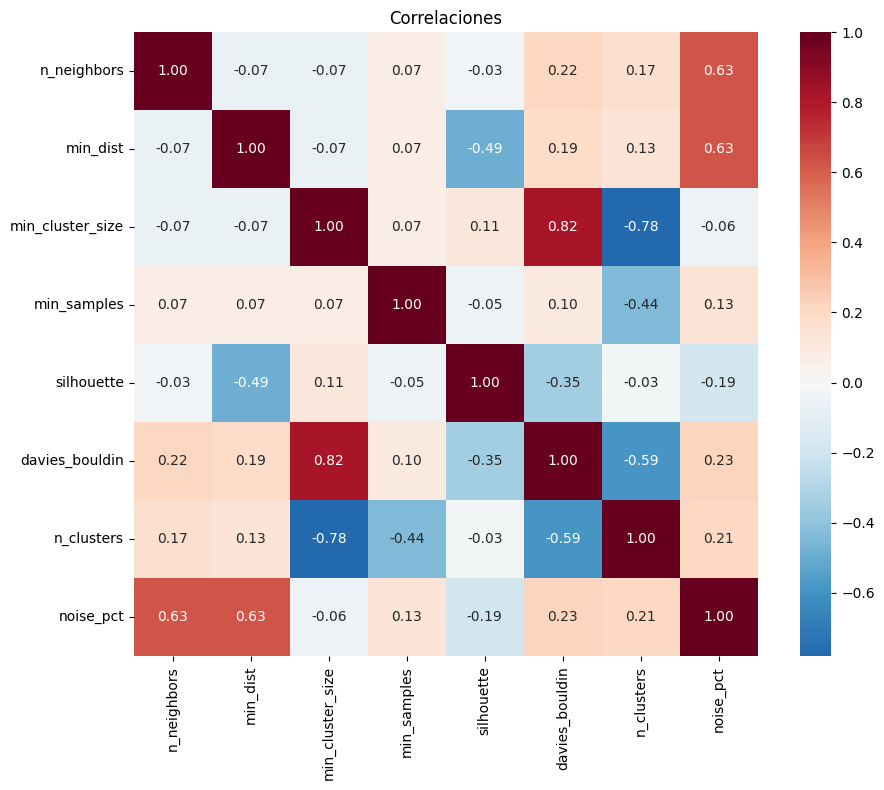

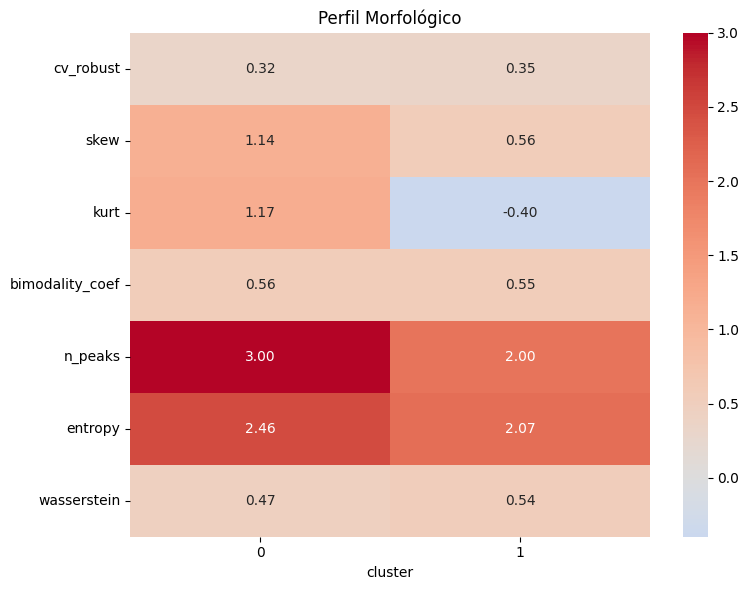


ESTADÍSTICAS CLUSTERING FINAL
Parámetros óptimos:
  n_neighbors=10, min_dist=0.0
  min_cluster_size=100, min_samples=5

Métricas:
  Silhouette: 0.608
  Davies-Bouldin: 0.620
  Calinski-Harabasz: 830.8
  Noise: 0.0%

Distribución por cluster:
cluster
0    169
1    210
Name: count, dtype: int64


In [40]:

# Caracterizar
top_pairs = [(r['roi_i'], r['roi_j']) for _, r in df_stable_diverse.head(50).iterrows()]
df_feat = characterize_distributions_enhanced(cleaned_rats, top_pairs)

# Features para clustering (robustos a outliers)
X = df_feat[['cv_robust', 'skew', 'bimodality_coef', 'iqr_norm', 'wasserstein', 'ks_stat', 'mean', 'median', 'kurt', 'n_peaks', 'entropy', 'kl_div', 'range_norm']].values

feature_cols = ['cv_robust', 'skew', 'kurt', 'bimodality_coef', 
                'n_peaks', 'entropy', 'wasserstein']

corr_cols = ['n_neighbors', 'min_dist', 'min_cluster_size', 'min_samples',
             'silhouette', 'davies_bouldin', 'n_clusters', 'noise_pct']

X = df_feat[feature_cols].dropna().values
X_scaled = RobustScaler().fit_transform(X)

# ===== GRID SEARCH =====
param_grid = {
    'n_neighbors': [10, 20],
    'min_dist': [0.0, 0.2],
    'min_cluster_size': [10, 100],  # más grande → menos clusters
    'min_samples': [5, 10]
}

results = []
print(f"Evaluando {len(list(ParameterGrid(param_grid)))} configuraciones...")

for i, params in enumerate(ParameterGrid(param_grid)):
    # UMAP
    reducer = UMAP(n_neighbors=params['n_neighbors'], 
                   min_dist=params['min_dist'],
                   n_components=2, n_jobs=-1)
    X_umap = reducer.fit_transform(X_scaled)
    
    # HDBSCAN
    clusterer = HDBSCAN(min_cluster_size=params['min_cluster_size'],
                        min_samples=params['min_samples'], 
                        core_dist_n_jobs=-1)
    labels = clusterer.fit_predict(X_umap)
    
    # Métricas (solo no-ruido)
    mask = labels != -1
    n_noise = (~mask).sum()
    n_clustered = mask.sum()
    n_clusters = len(set(labels[mask])) if n_clustered > 0 else 0
    
    if n_clustered > 20 and n_clusters > 1:
        sil = silhouette_score(X_umap[mask], labels[mask])
        db = davies_bouldin_score(X_umap[mask], labels[mask])
        ch = calinski_harabasz_score(X_umap[mask], labels[mask])
        noise_pct = 100 * n_noise / len(labels)
        
        results.append({
            **params, 
            'silhouette': sil, 
            'davies_bouldin': db,
            'calinski_harabasz': ch,
            'n_clusters': n_clusters, 
            'noise_pct': noise_pct,
            'n_clustered': n_clustered
        })
    
    if (i+1) % 20 == 0:
        print(f"  {i+1}/{len(list(ParameterGrid(param_grid)))} completado")

df_grid = pd.DataFrame(results)

# Mejor configuración (multiobjetivo)
# Cambiar función de score
df_grid['score'] = (
    df_grid['silhouette'] / df_grid['silhouette'].max() - 
    df_grid['davies_bouldin'] / df_grid['davies_bouldin'].max() +
    df_grid['calinski_harabasz'] / df_grid['calinski_harabasz'].max() -
    df_grid['noise_pct'] / 100 -
    abs(df_grid['n_clusters'] - 4) / 10  # penaliza alejarse de k=4
)
df_grid = df_grid.sort_values('score', ascending=False)

print(f"\n✓ Grid search completo: {len(df_grid)} configuraciones válidas")
print("\nTop 5 configuraciones:")
print(df_grid.head(5)[['n_neighbors', 'min_dist', 'min_cluster_size', 'min_samples', 
                        'n_clusters', 'silhouette', 'noise_pct']].to_string(index=False))

# ===== CLUSTERING FINAL =====
best = df_grid.iloc[0]
reducer_final = UMAP(n_neighbors=int(best['n_neighbors']), 
                     min_dist=best['min_dist'],
                     n_components=2, random_state=42)
X_umap_final = reducer_final.fit_transform(X_scaled)

clusterer_final = HDBSCAN(min_cluster_size=int(best['min_cluster_size']),
                          min_samples=int(best['min_samples']))
df_feat['cluster'] = clusterer_final.fit_predict(X_umap_final)

mask_final = df_feat['cluster'] != -1
print(f"\nClustering final: {df_feat['cluster'].nunique()-1} clusters + {(~mask_final).sum()} noise")

# ===== PLOTS PRINCIPALES (4x4) =====
fig1 = plt.figure(figsize=(16, 14))
gs = fig1.add_gridspec(4, 4, hspace=0.35, wspace=0.35)

# Fila 1: Métricas vs parámetros
ax1 = fig1.add_subplot(gs[0, :2])
for metric in ['silhouette', 'davies_bouldin']:
    grouped = df_grid.groupby('n_neighbors')[metric].mean()
    ax1.plot(grouped.index, grouped.values, 'o-', label=metric, lw=2)
ax1.set_xlabel('n_neighbors'); ax1.legend(); ax1.grid(alpha=0.3)

ax2 = fig1.add_subplot(gs[0, 2:])
grouped = df_grid.groupby('min_cluster_size')['noise_pct'].mean()
ax2.bar(grouped.index, grouped.values, alpha=0.7)
ax2.set_xlabel('min_cluster_size'); ax2.set_ylabel('% Noise')

# Fila 2: Scatter n_clusters
ax3 = fig1.add_subplot(gs[1, :])
for md in sorted(df_grid['min_dist'].unique()):
    subset = df_grid[df_grid['min_dist'] == md]
    ax3.scatter(subset['n_neighbors'], subset['n_clusters'], 
               label=f'min_dist={md}', s=40)
ax3.legend(); ax3.grid(alpha=0.3)

# Fila 3-4: UMAP grande
ax4 = fig1.add_subplot(gs[2:, :])
scatter = ax4.scatter(X_umap_final[:, 0], X_umap_final[:, 1], 
                     c=df_feat['cluster'], cmap='tab10', s=60, alpha=0.7)
ax4.set_xlabel('UMAP 1'); ax4.set_ylabel('UMAP 2')
plt.colorbar(scatter, ax=ax4)

plt.suptitle(f'UMAP+HDBSCAN Optimization (th=0.0)', fontsize=14)
plt.savefig(f'clustering_main_th_0.0.png', dpi=150, bbox_inches='tight')
plt.show()

# ===== HEATMAPS SEPARADOS =====
# Correlaciones
fig2, ax = plt.subplots(1, 1, figsize=(10, 8))
corr_matrix = df_grid[corr_cols].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='RdBu_r', 
            center=0, ax=ax, square=True)
ax.set_title('Correlaciones')
plt.tight_layout()
plt.savefig(f'correlations_th_0.0.png', dpi=150)
plt.show()

# Perfil clusters
fig3, ax = plt.subplots(1, 1, figsize=(8, 6))
cluster_profiles = df_feat[mask_final].groupby('cluster')[feature_cols].median()
sns.heatmap(cluster_profiles.T, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, ax=ax)
ax.set_title('Perfil Morfológico')
plt.tight_layout()
plt.savefig(f'profiles_th_0.0.png', dpi=150)
plt.show()

# ===== ESTADÍSTICAS FINALES =====
print("\n" + "="*70)
print("ESTADÍSTICAS CLUSTERING FINAL")
print("="*70)
print(f"Parámetros óptimos:")
print(f"  n_neighbors={int(best['n_neighbors'])}, min_dist={best['min_dist']}")
print(f"  min_cluster_size={int(best['min_cluster_size'])}, min_samples={int(best['min_samples'])}")
print(f"\nMétricas:")
print(f"  Silhouette: {best['silhouette']:.3f}")
print(f"  Davies-Bouldin: {best['davies_bouldin']:.3f}")
print(f"  Calinski-Harabasz: {best['calinski_harabasz']:.1f}")
print(f"  Noise: {best['noise_pct']:.1f}%")
print(f"\nDistribución por cluster:")
print(df_feat['cluster'].value_counts().sort_index())

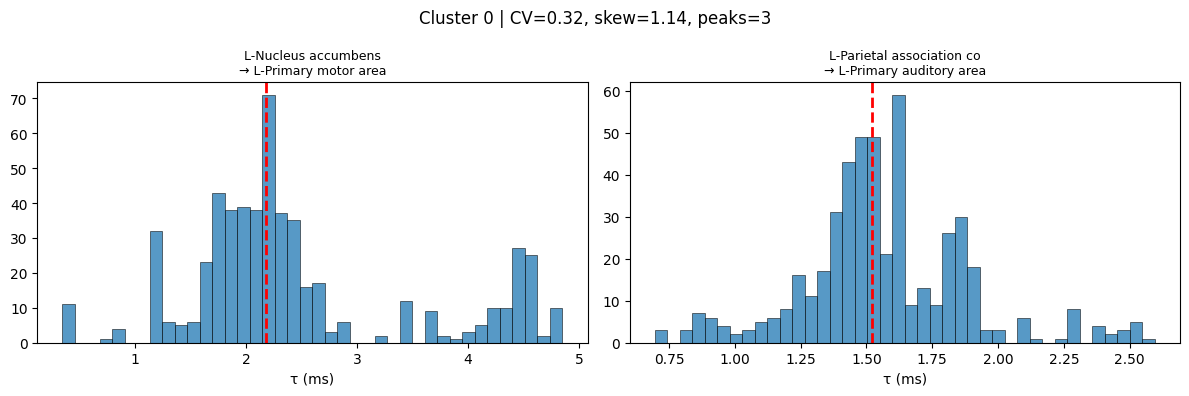

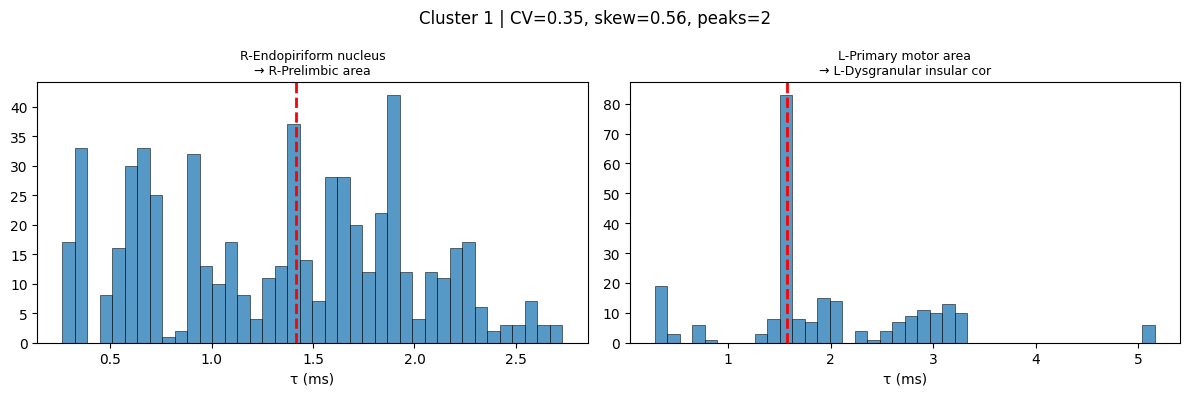

In [41]:
# 2 ejemplos por cluster
np.random.seed(42)
for c in sorted(df_feat['cluster'].unique()):
    # Tomar 2 pares distintos del cluster
    cluster_pairs = df_feat[df_feat['cluster'] == c][['roi_i', 'roi_j', 'rat_id']].drop_duplicates(['roi_i', 'roi_j']).head(2)
    
    if len(cluster_pairs) == 0:
        continue
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    cluster_profile = df_feat[df_feat['cluster'] == c][['cv_robust', 'skew', 'n_peaks']].median()
    
    for idx, (_, row) in enumerate(cluster_pairs.iterrows()):
        i, j, rat = int(row['roi_i']), int(row['roi_j']), row['rat_id']
        tau_ms = cleaned_rats[rat][(i,j)][:, COL_TAU] * 1e3
        
        axes[idx].hist(tau_ms, bins=40, alpha=0.75, edgecolor='k', linewidth=0.5)
        axes[idx].axvline(np.median(tau_ms), color='r', ls='--', lw=2)
        axes[idx].set_title(f"{roi_label(i, name_map)[:25]}\n→ {roi_label(j, name_map)[:25]}", fontsize=9)
        axes[idx].set_xlabel('τ (ms)')
    
    fig.suptitle(f'Cluster {c} | CV={cluster_profile["cv_robust"]:.2f}, skew={cluster_profile["skew"]:.2f}, peaks={cluster_profile["n_peaks"]:.0f}', fontsize=12)
    plt.tight_layout()
    plt.show()